## Metrics

汇总常见2分类的指标，例如: AUC，ROC曲线，ACC, 敏感性， 特异性，精确度，召回率，PPV, NPV, F1

具体的介绍，可以参考一下：https://blog.csdn.net/sunflower_sara/article/details/81214897

In [1]:
import os
import pandas as pd
from datetime import datetime
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
group_info = pd.read_csv(get_param_in_cwd('label_file'))[['ID', 'group']]
group_info['ID'] = group_info['ID'].map(lambda x: x.replace('.png', '.gz'))
group_info

,ID,group
0,DONG HUIP00343158.nii.gz,train
1,YAO YU MING_P00096109.nii.gz,train
2,DENG YUE YINGP00332485.nii.gz,train
3,JIANG XIU JUAN_P00104388.nii.gz,train
4,DAI_XIAO_HUI_P00307303.nii.gz,train
...,...,...
284,ZHAO_YUN_P00310065.nii.gz,test
285,ZHAO_ZHANG_ZHI_P00206369.nii.gz,test
286,ZHENG_XI_DE_P00266862.nii.gz,test
287,ZHOU_RONG_P00306340.nii.gz,test


# 所有模型汇总

CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


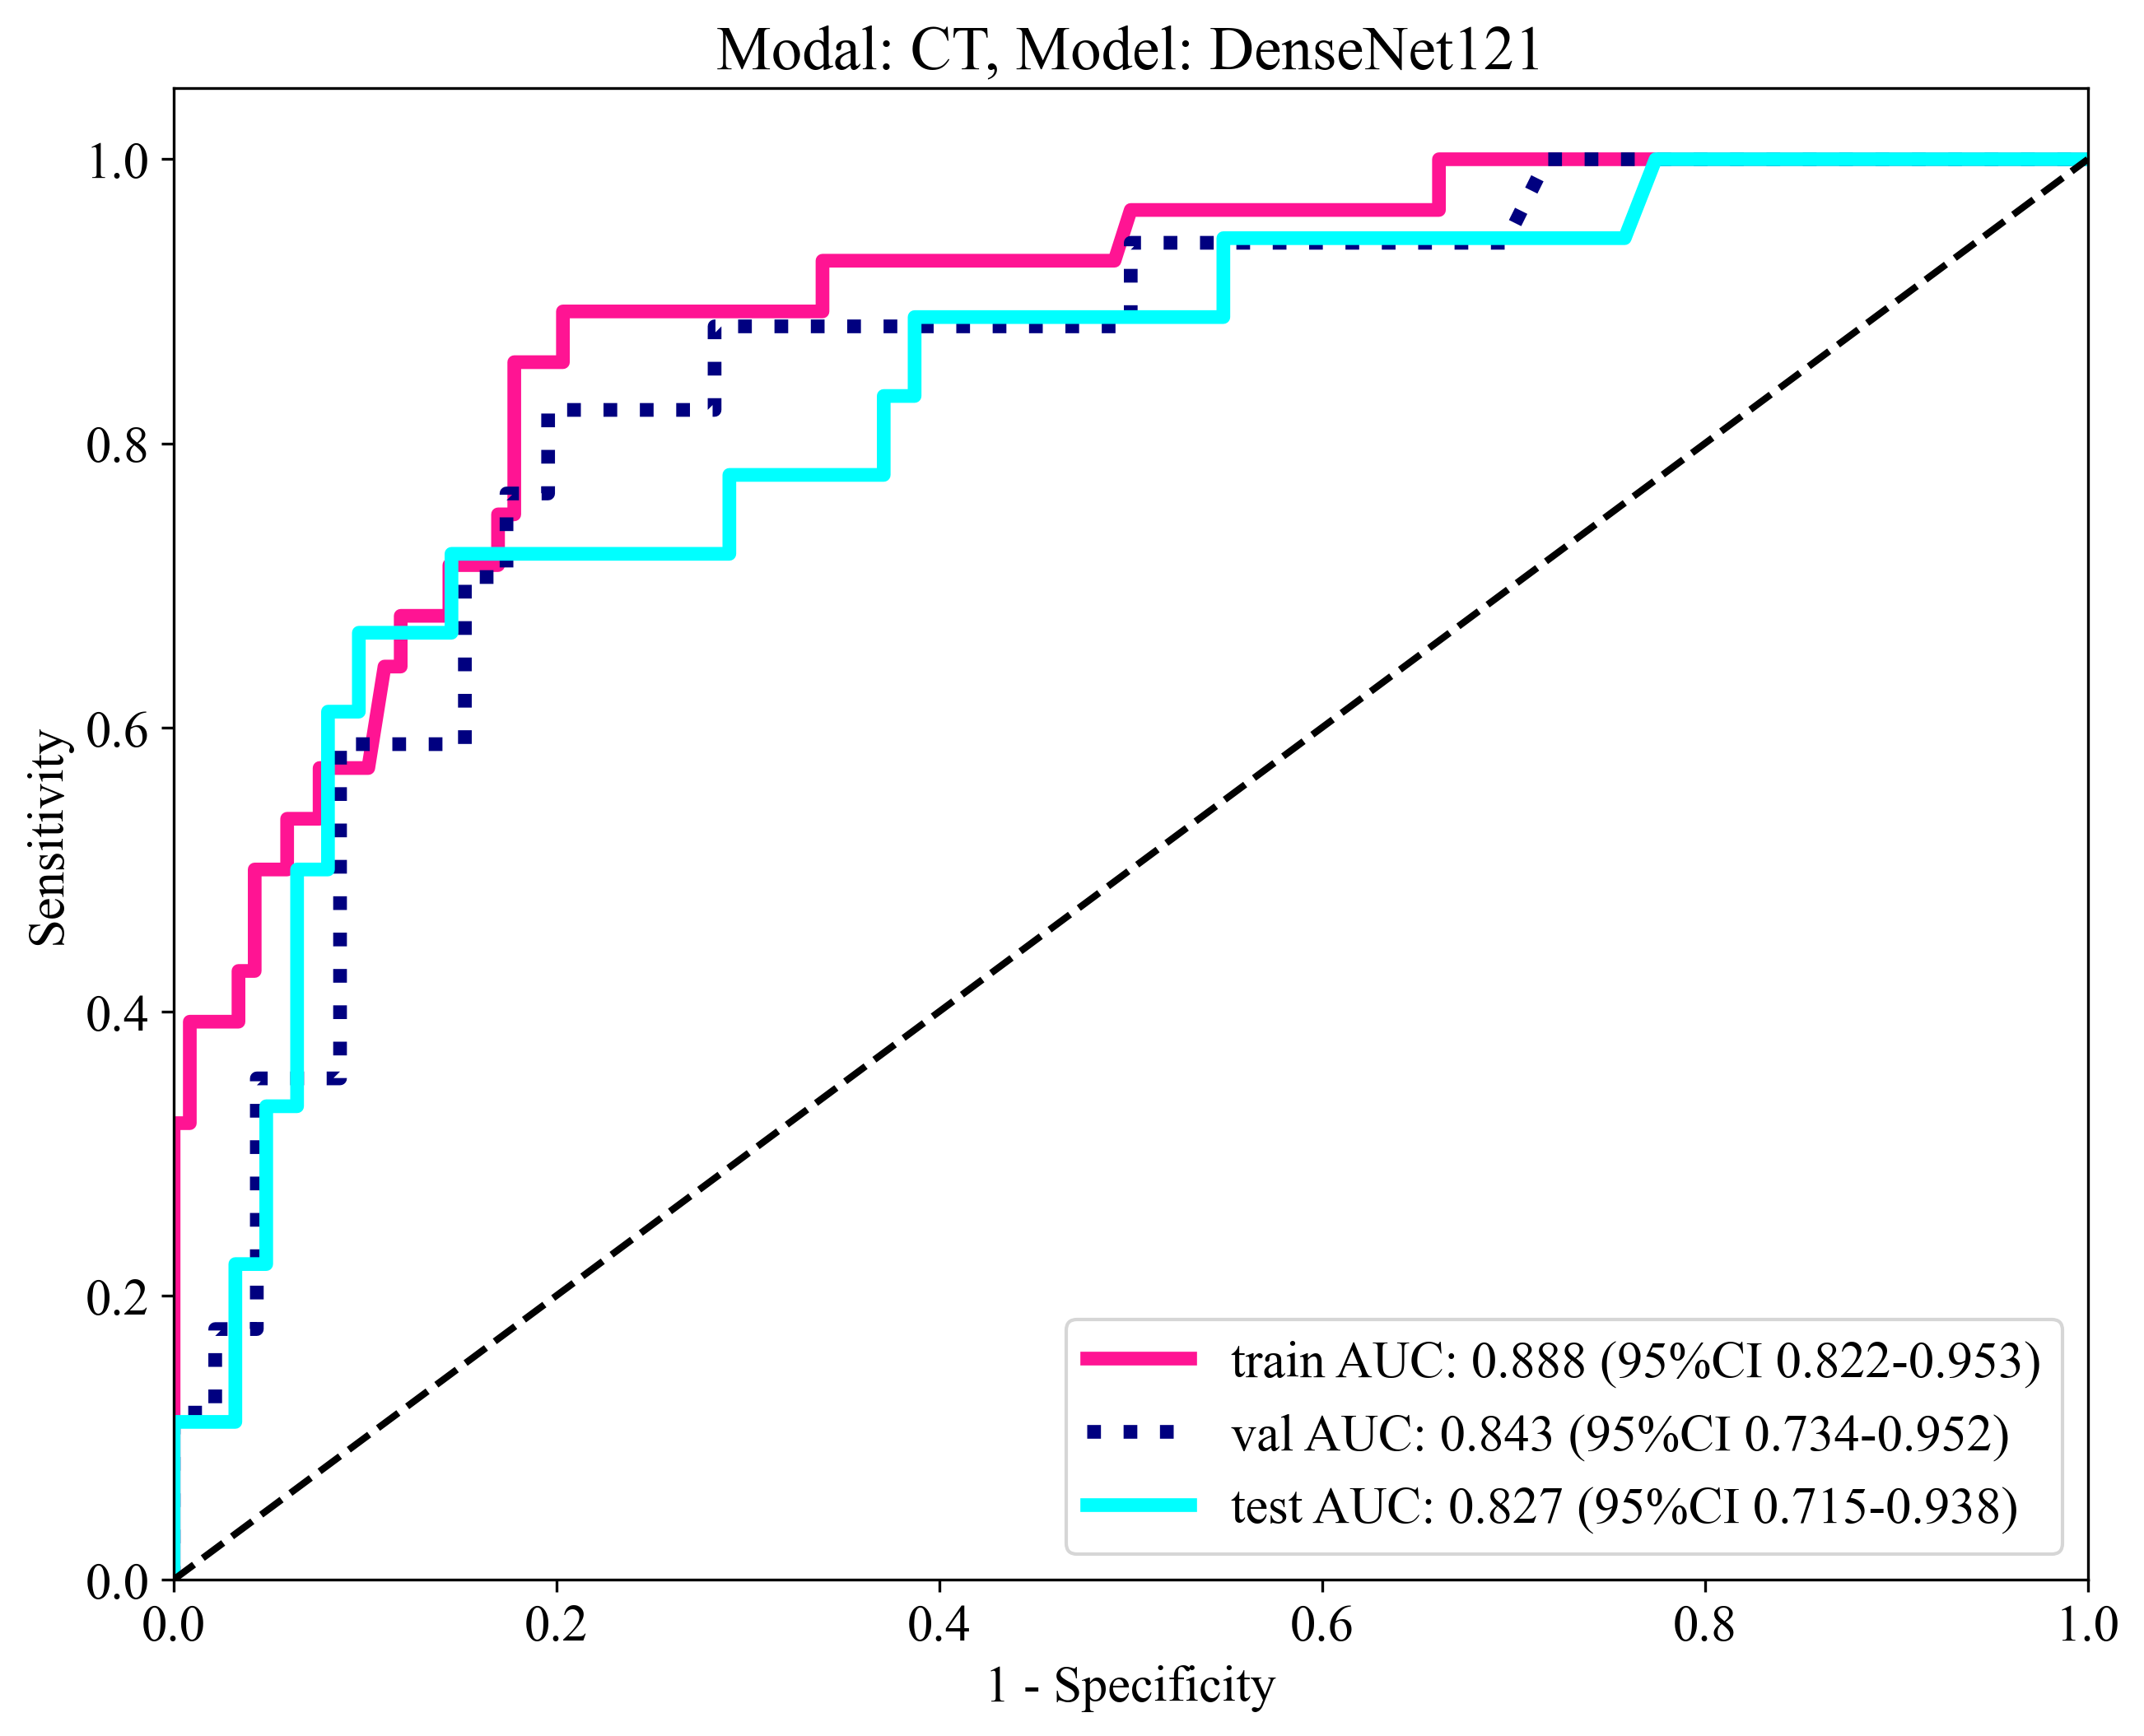

CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


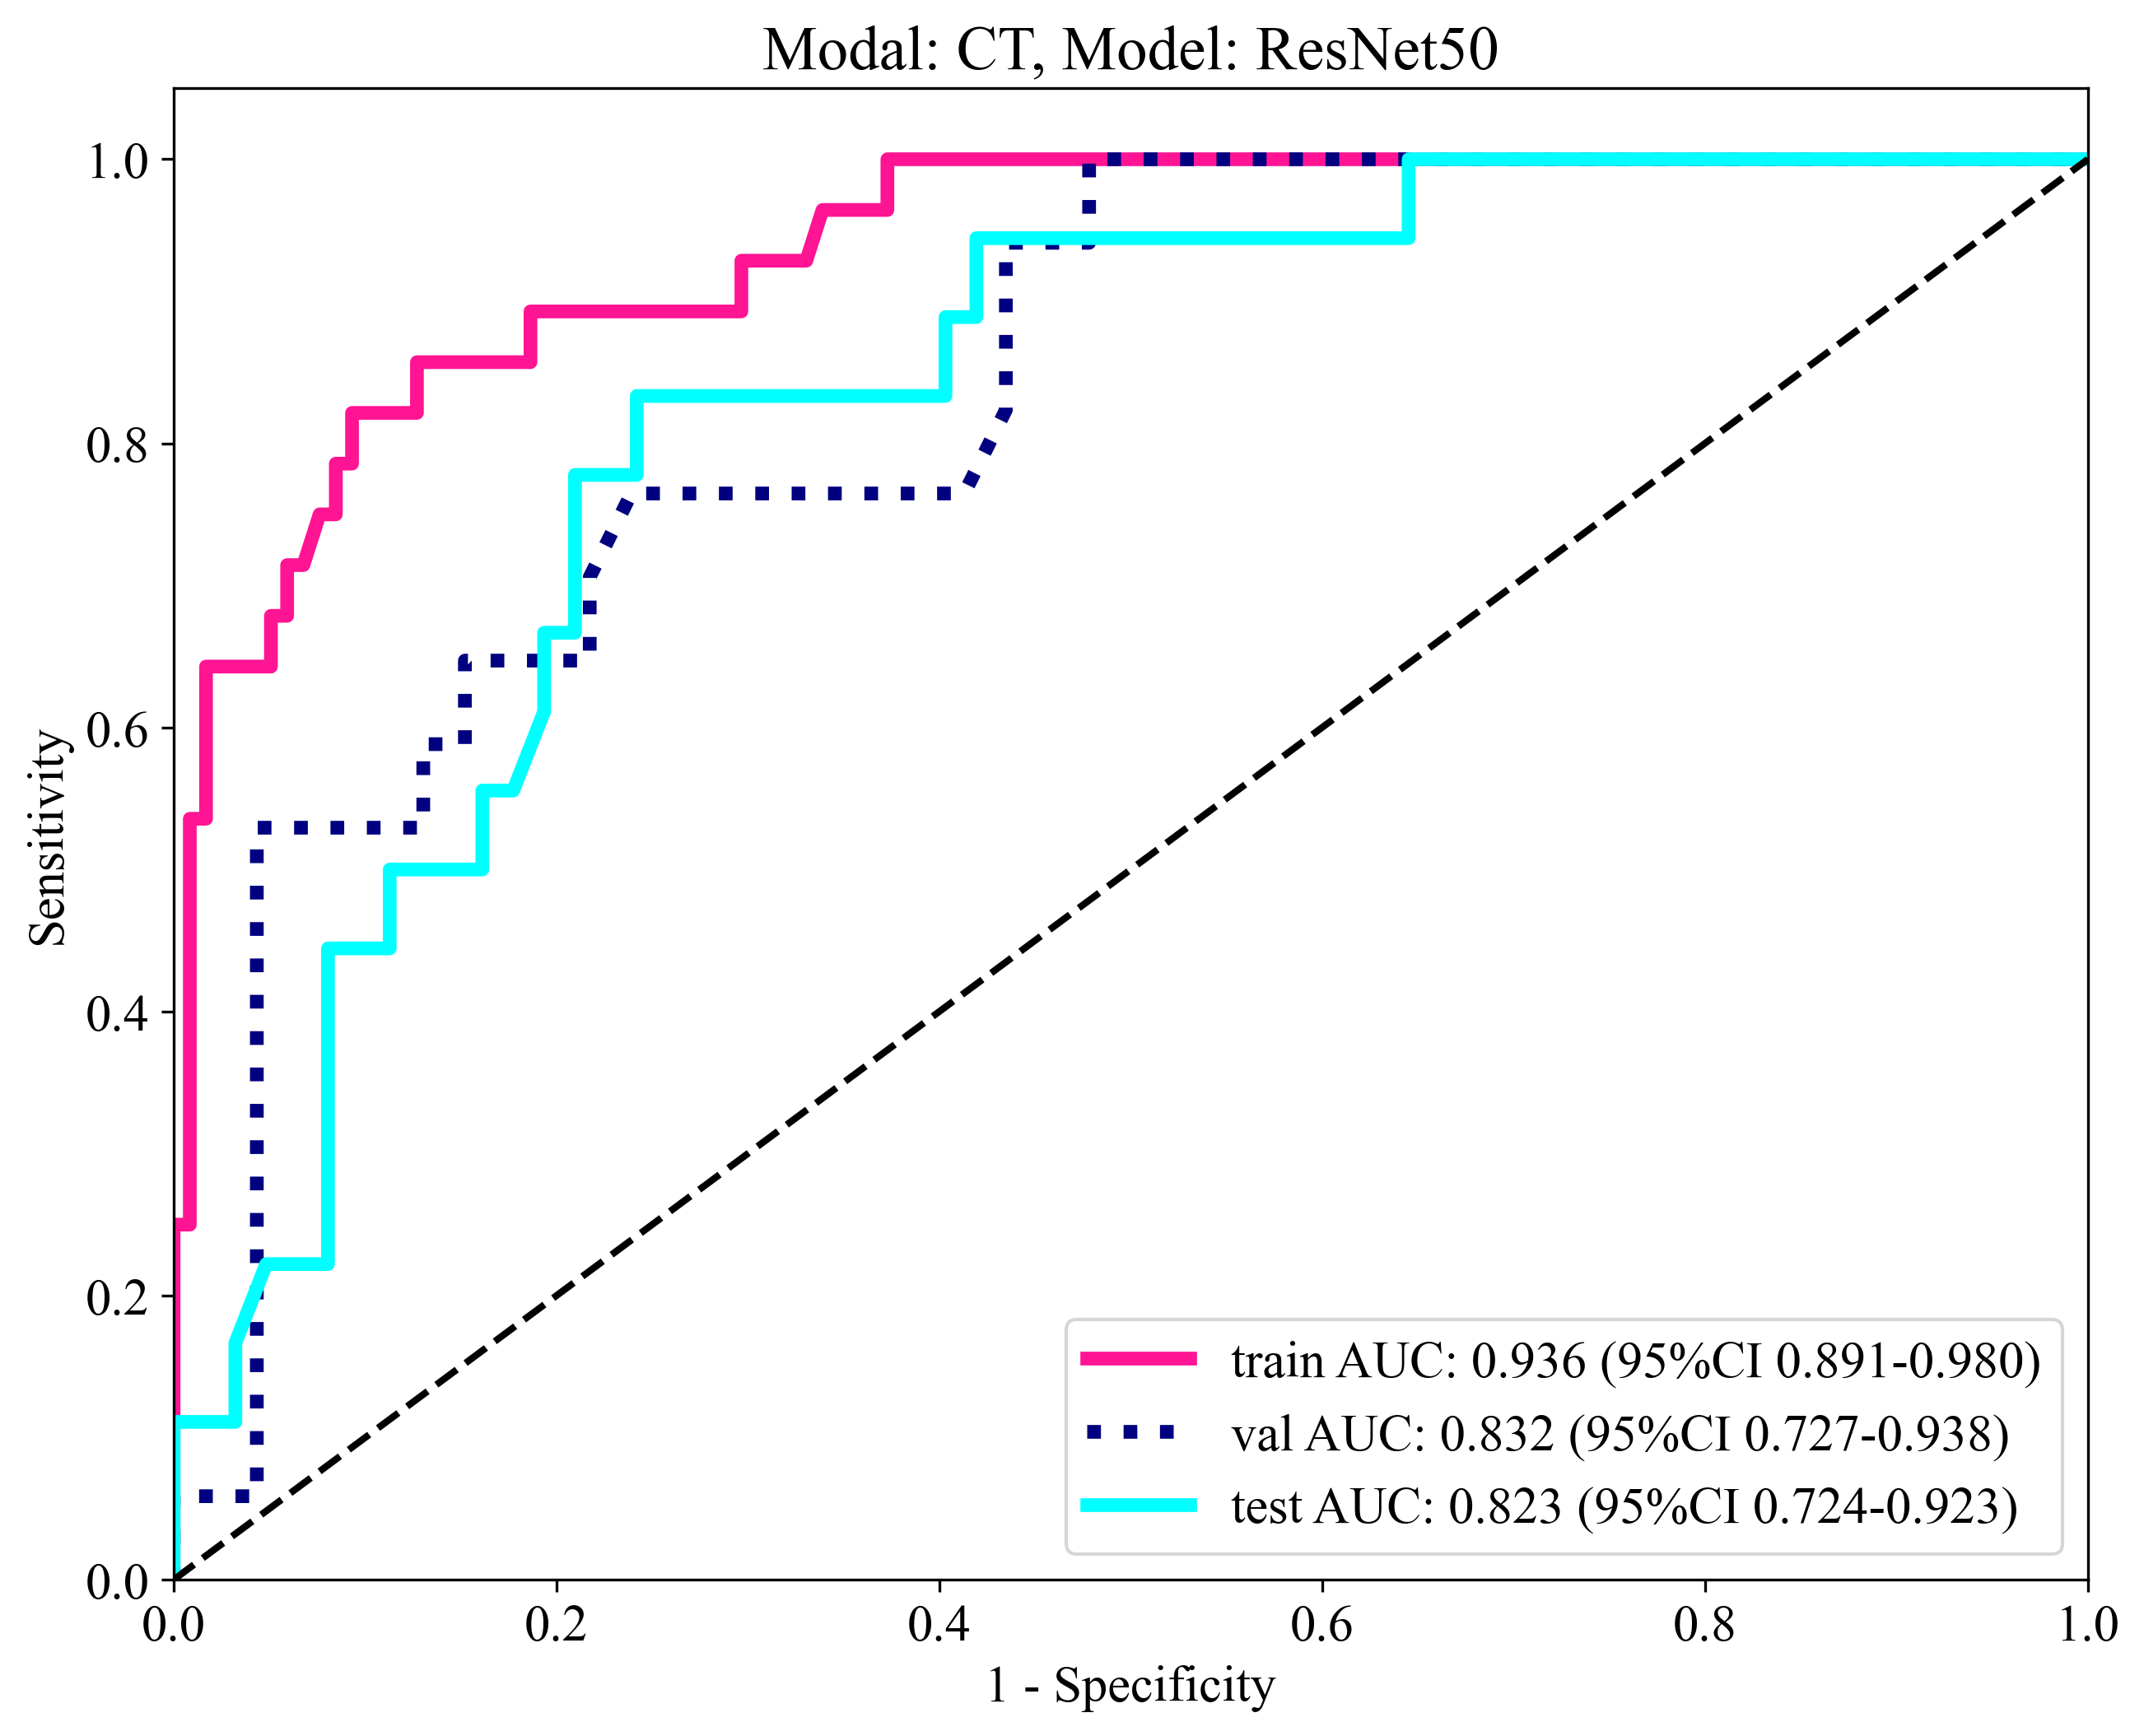

CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


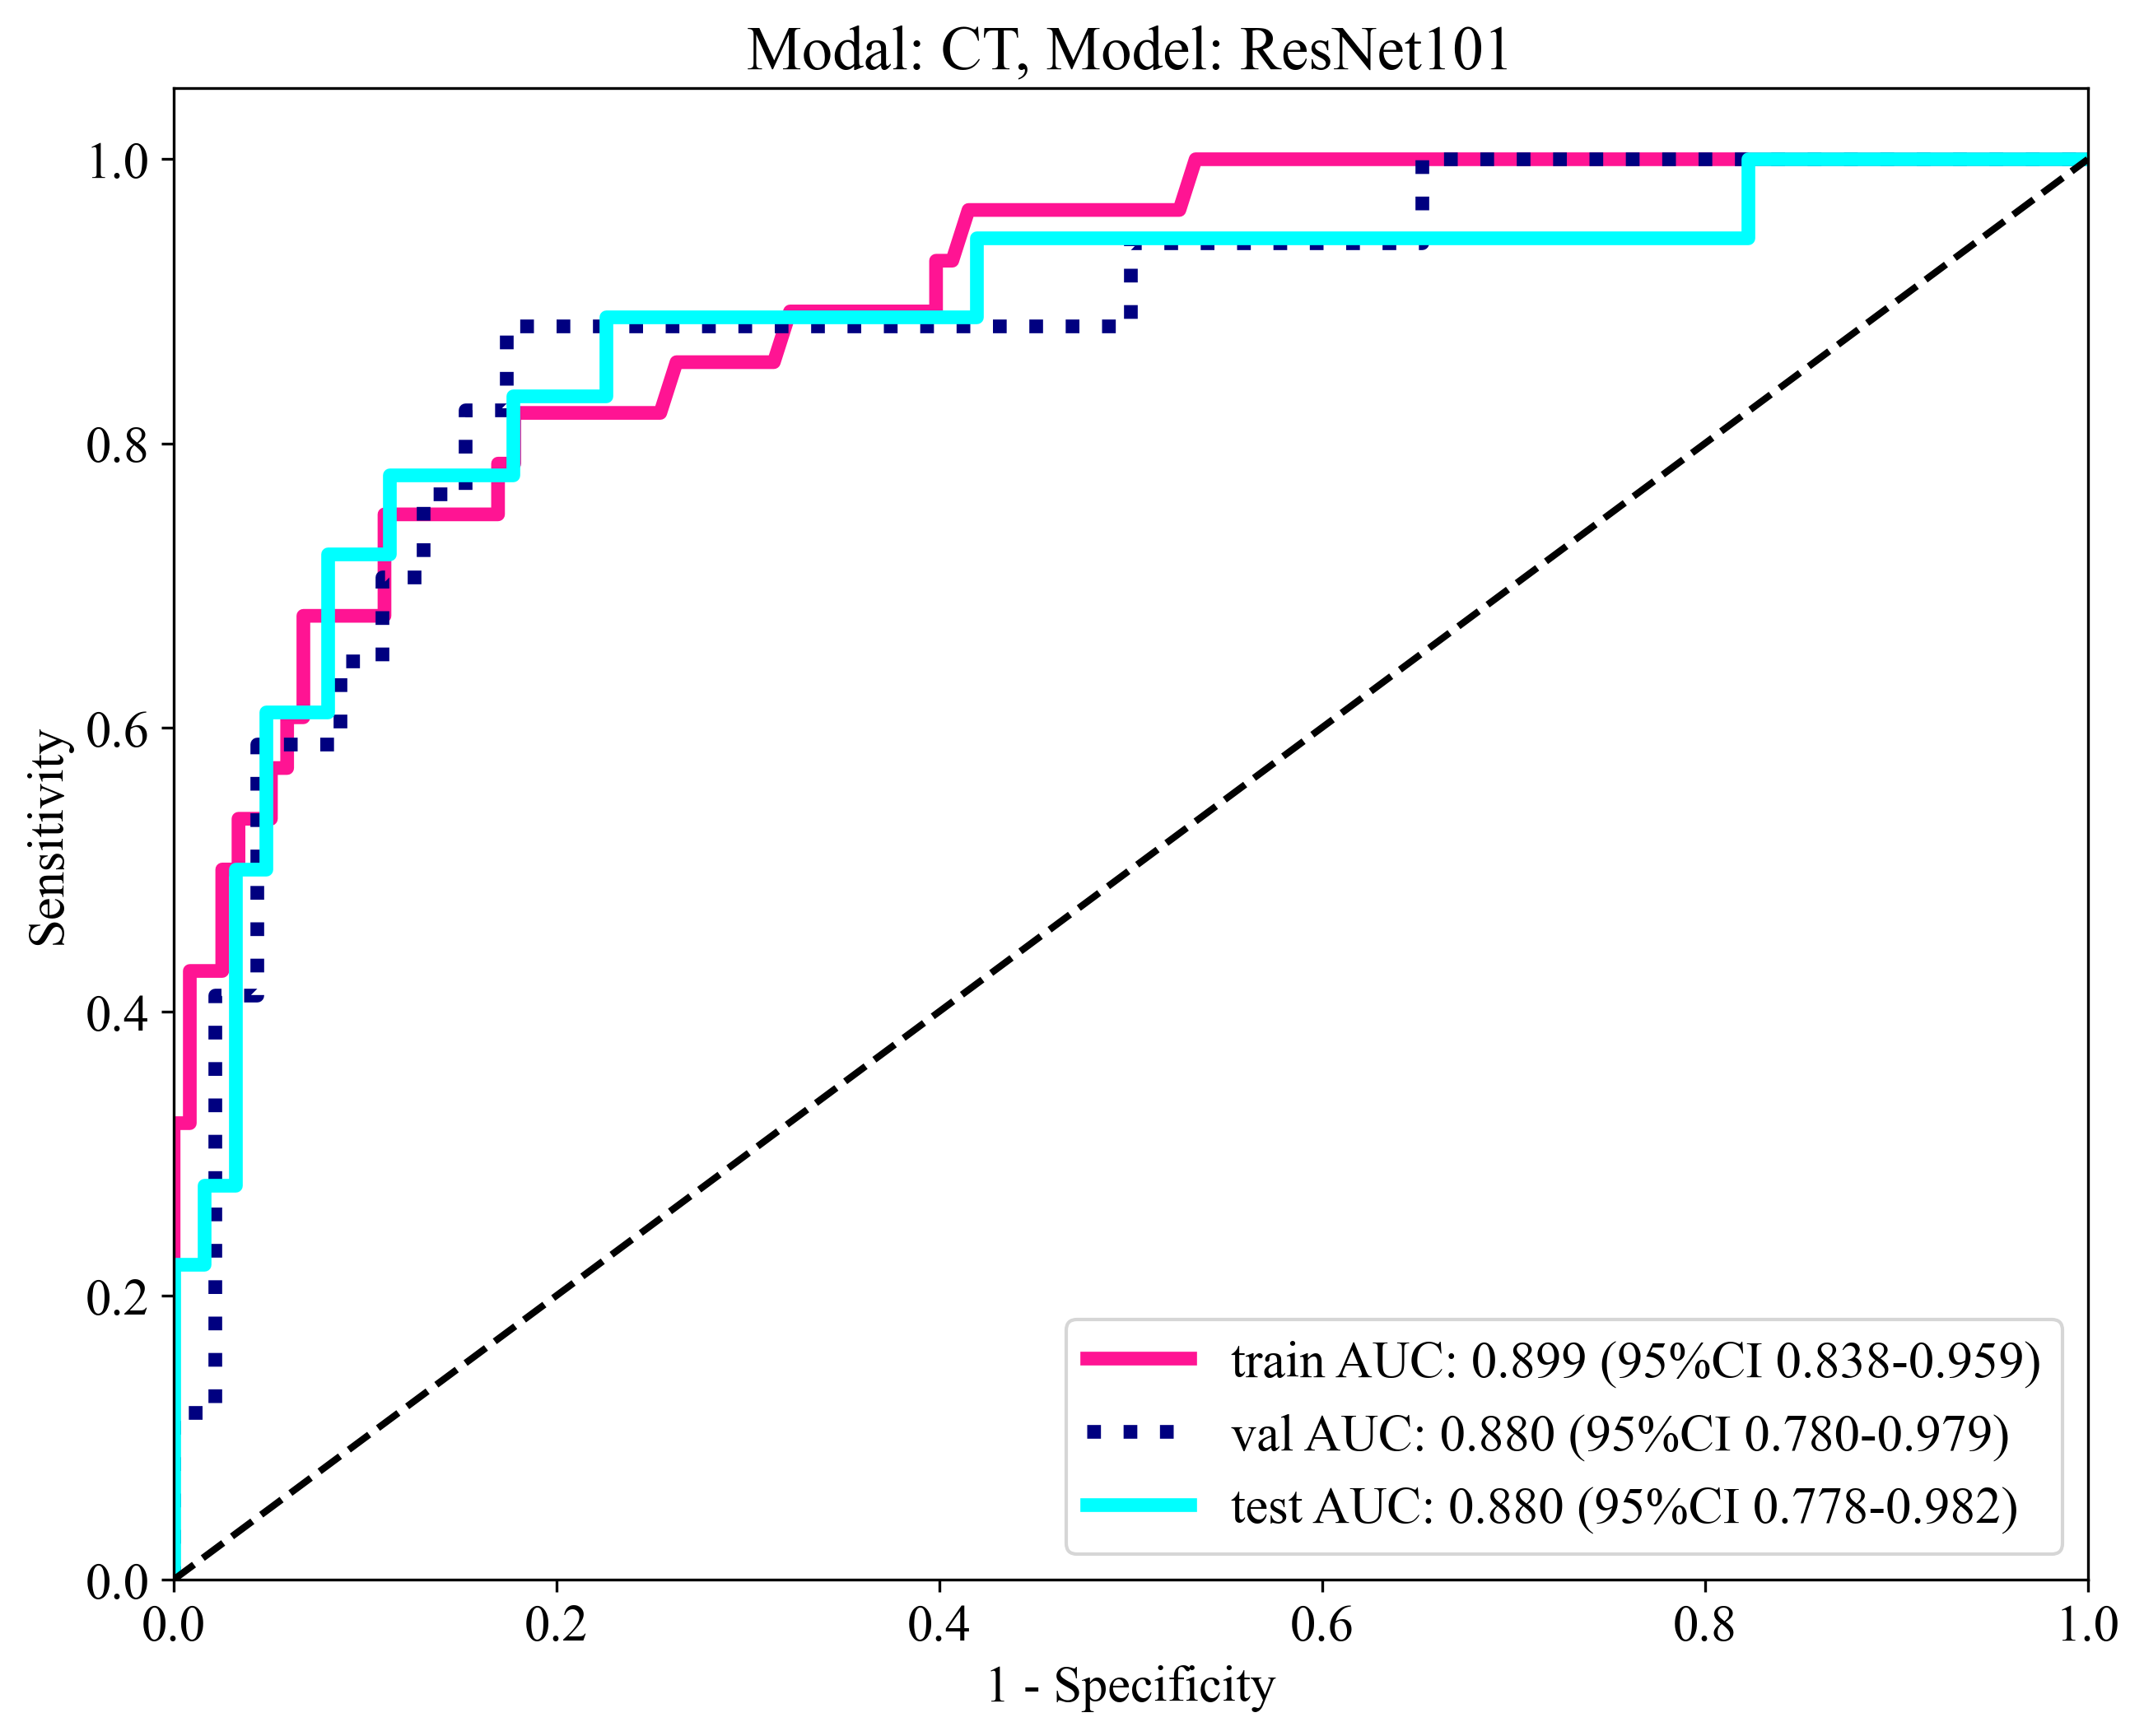

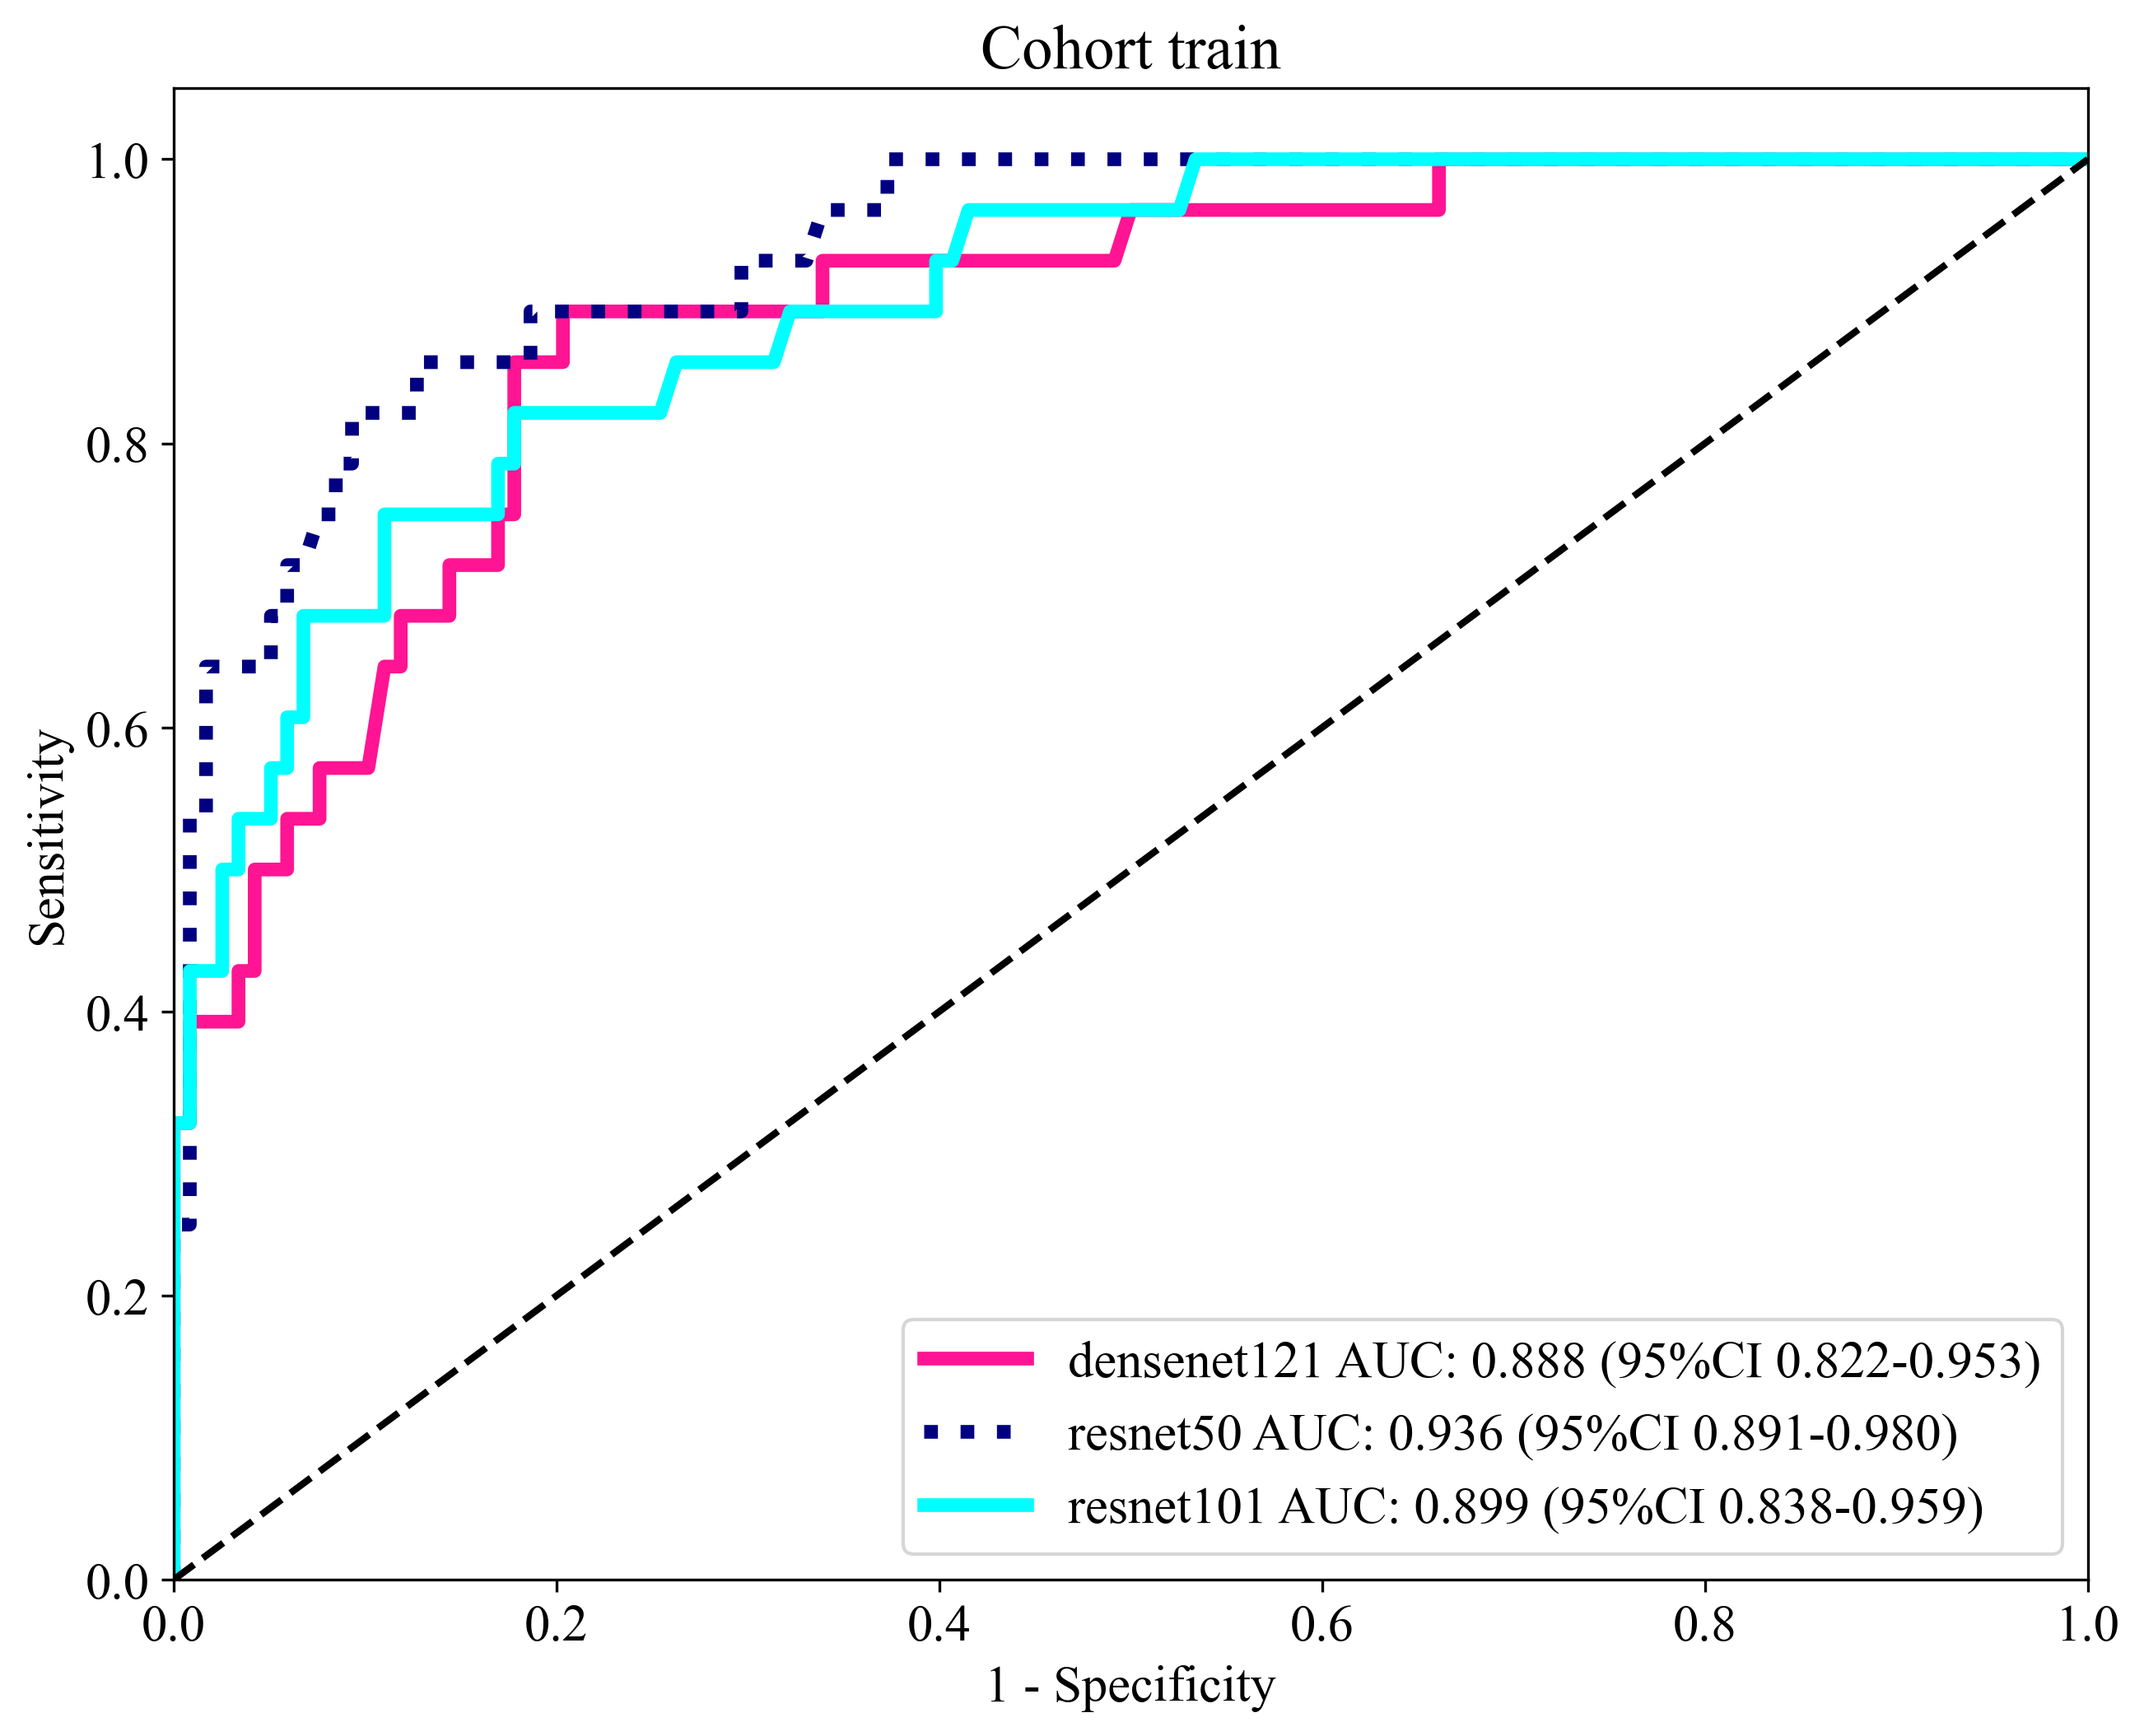

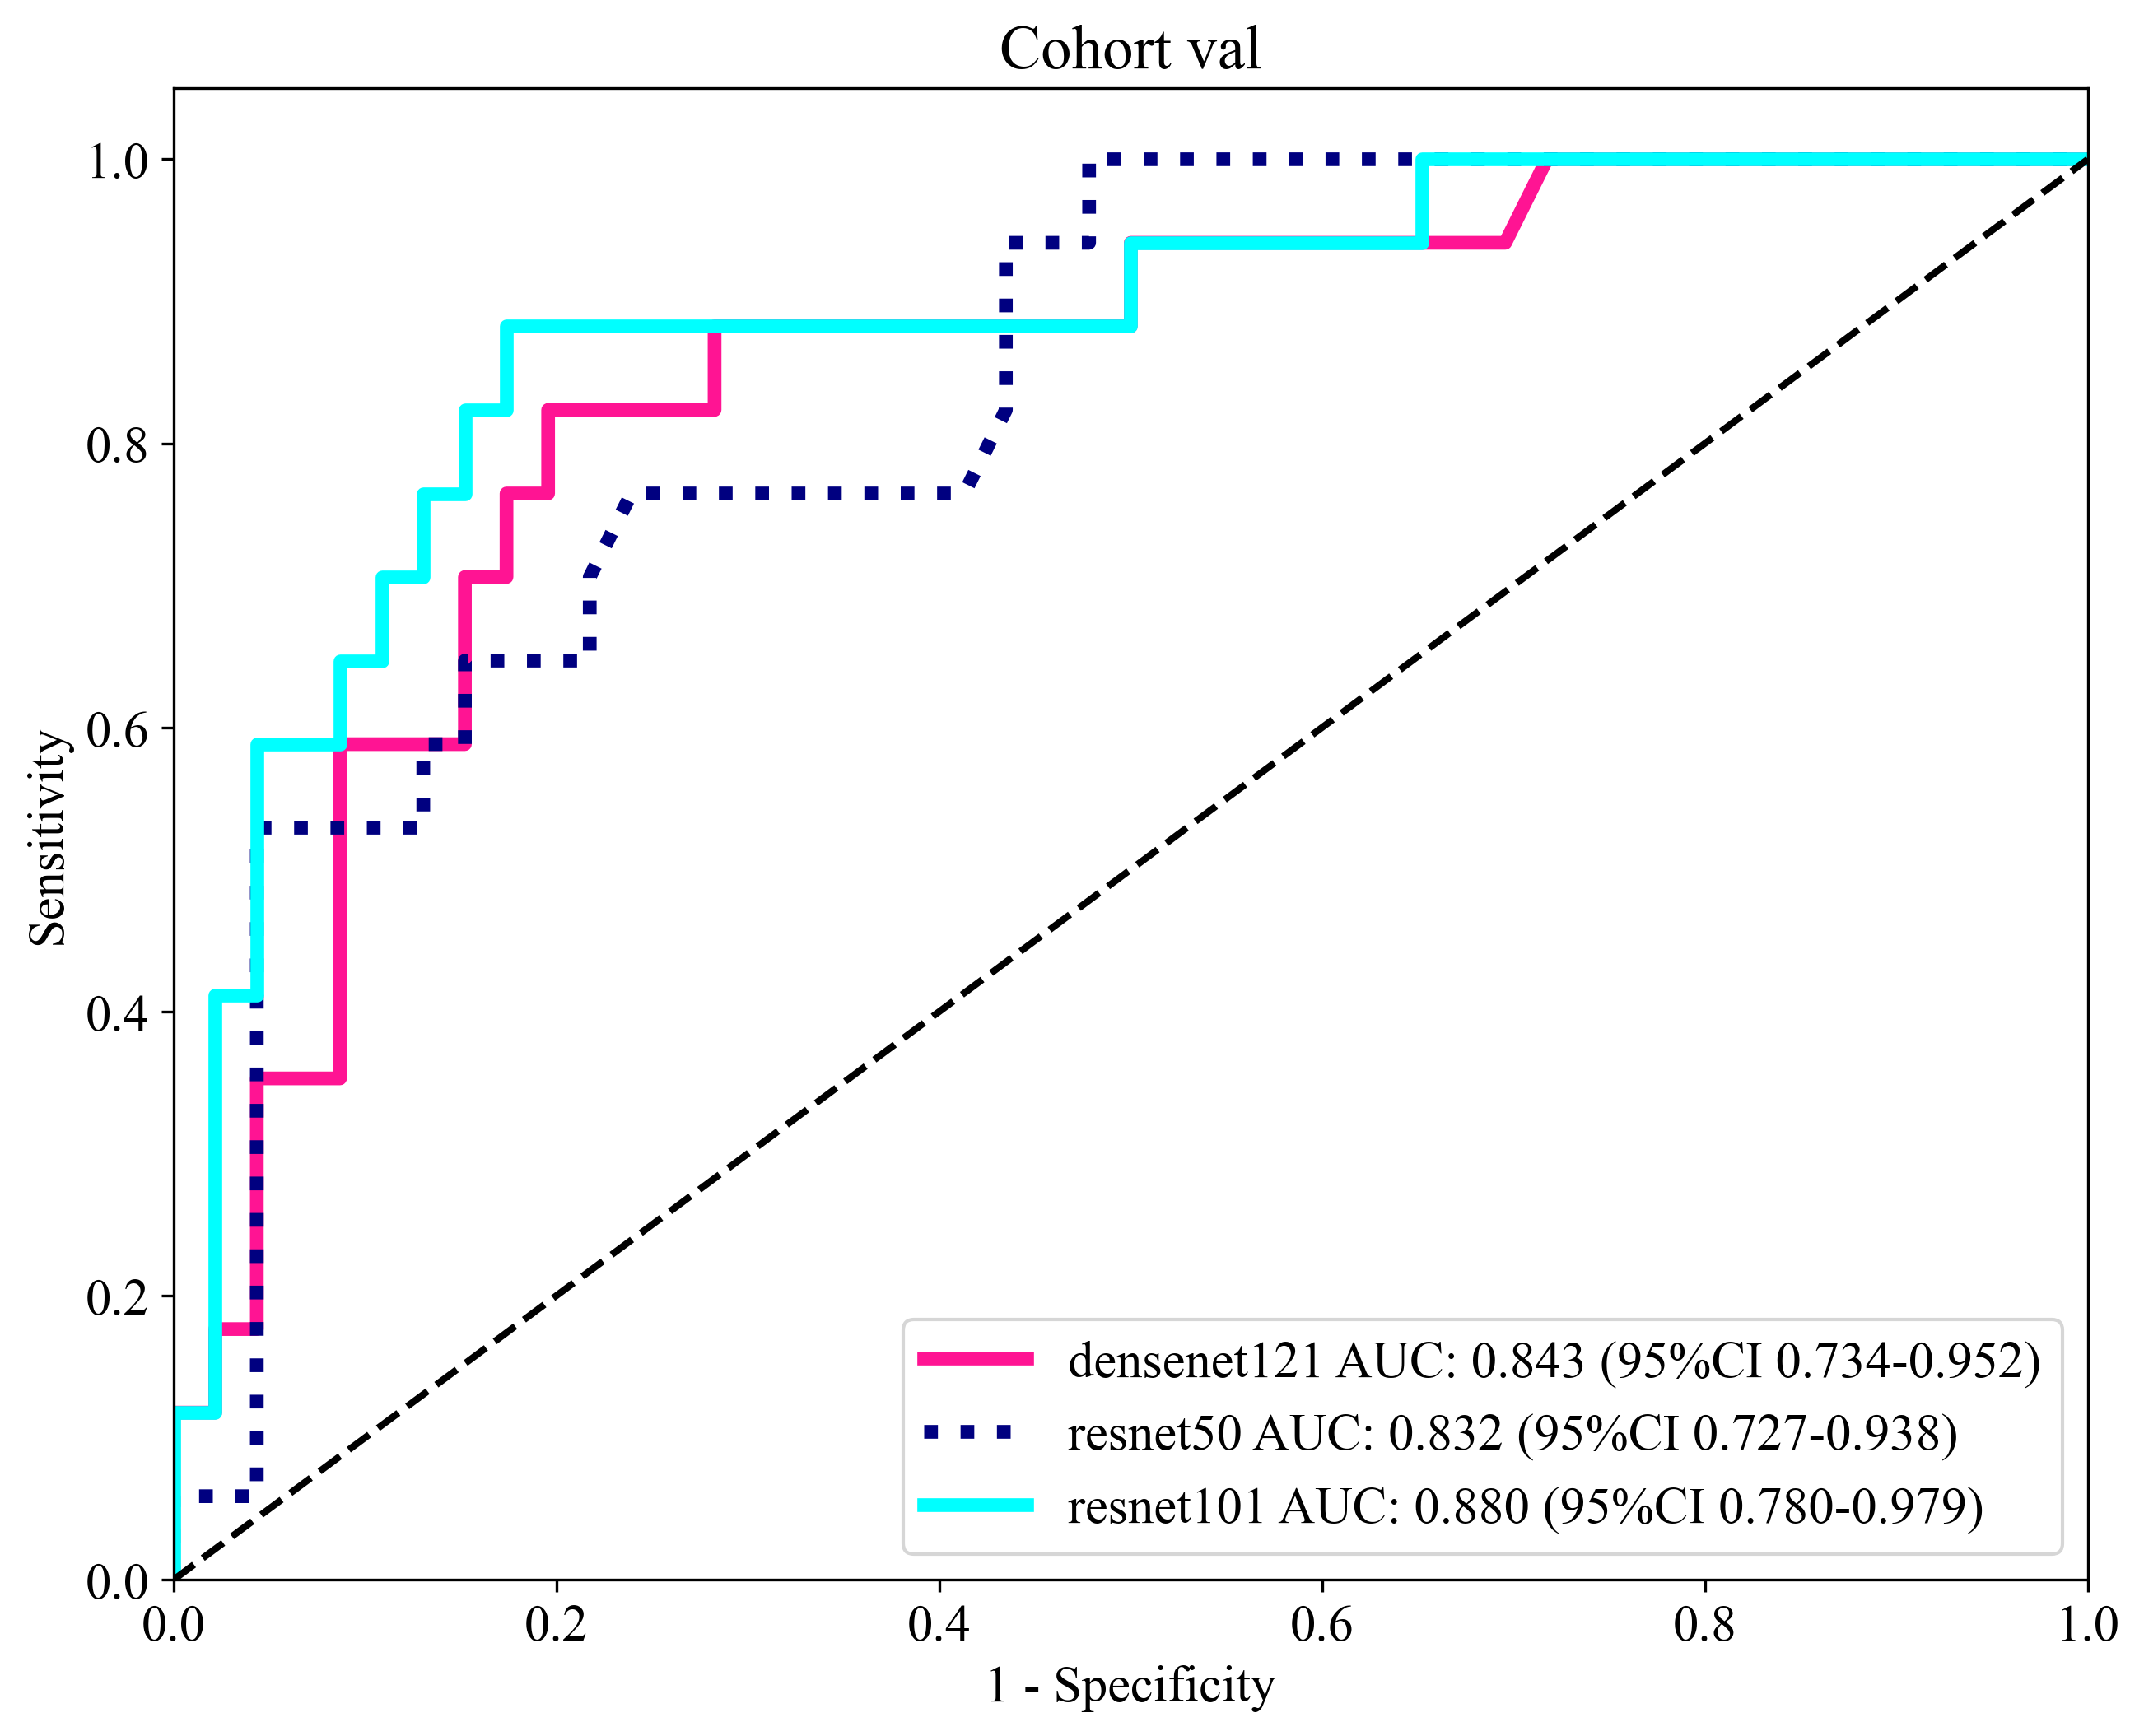

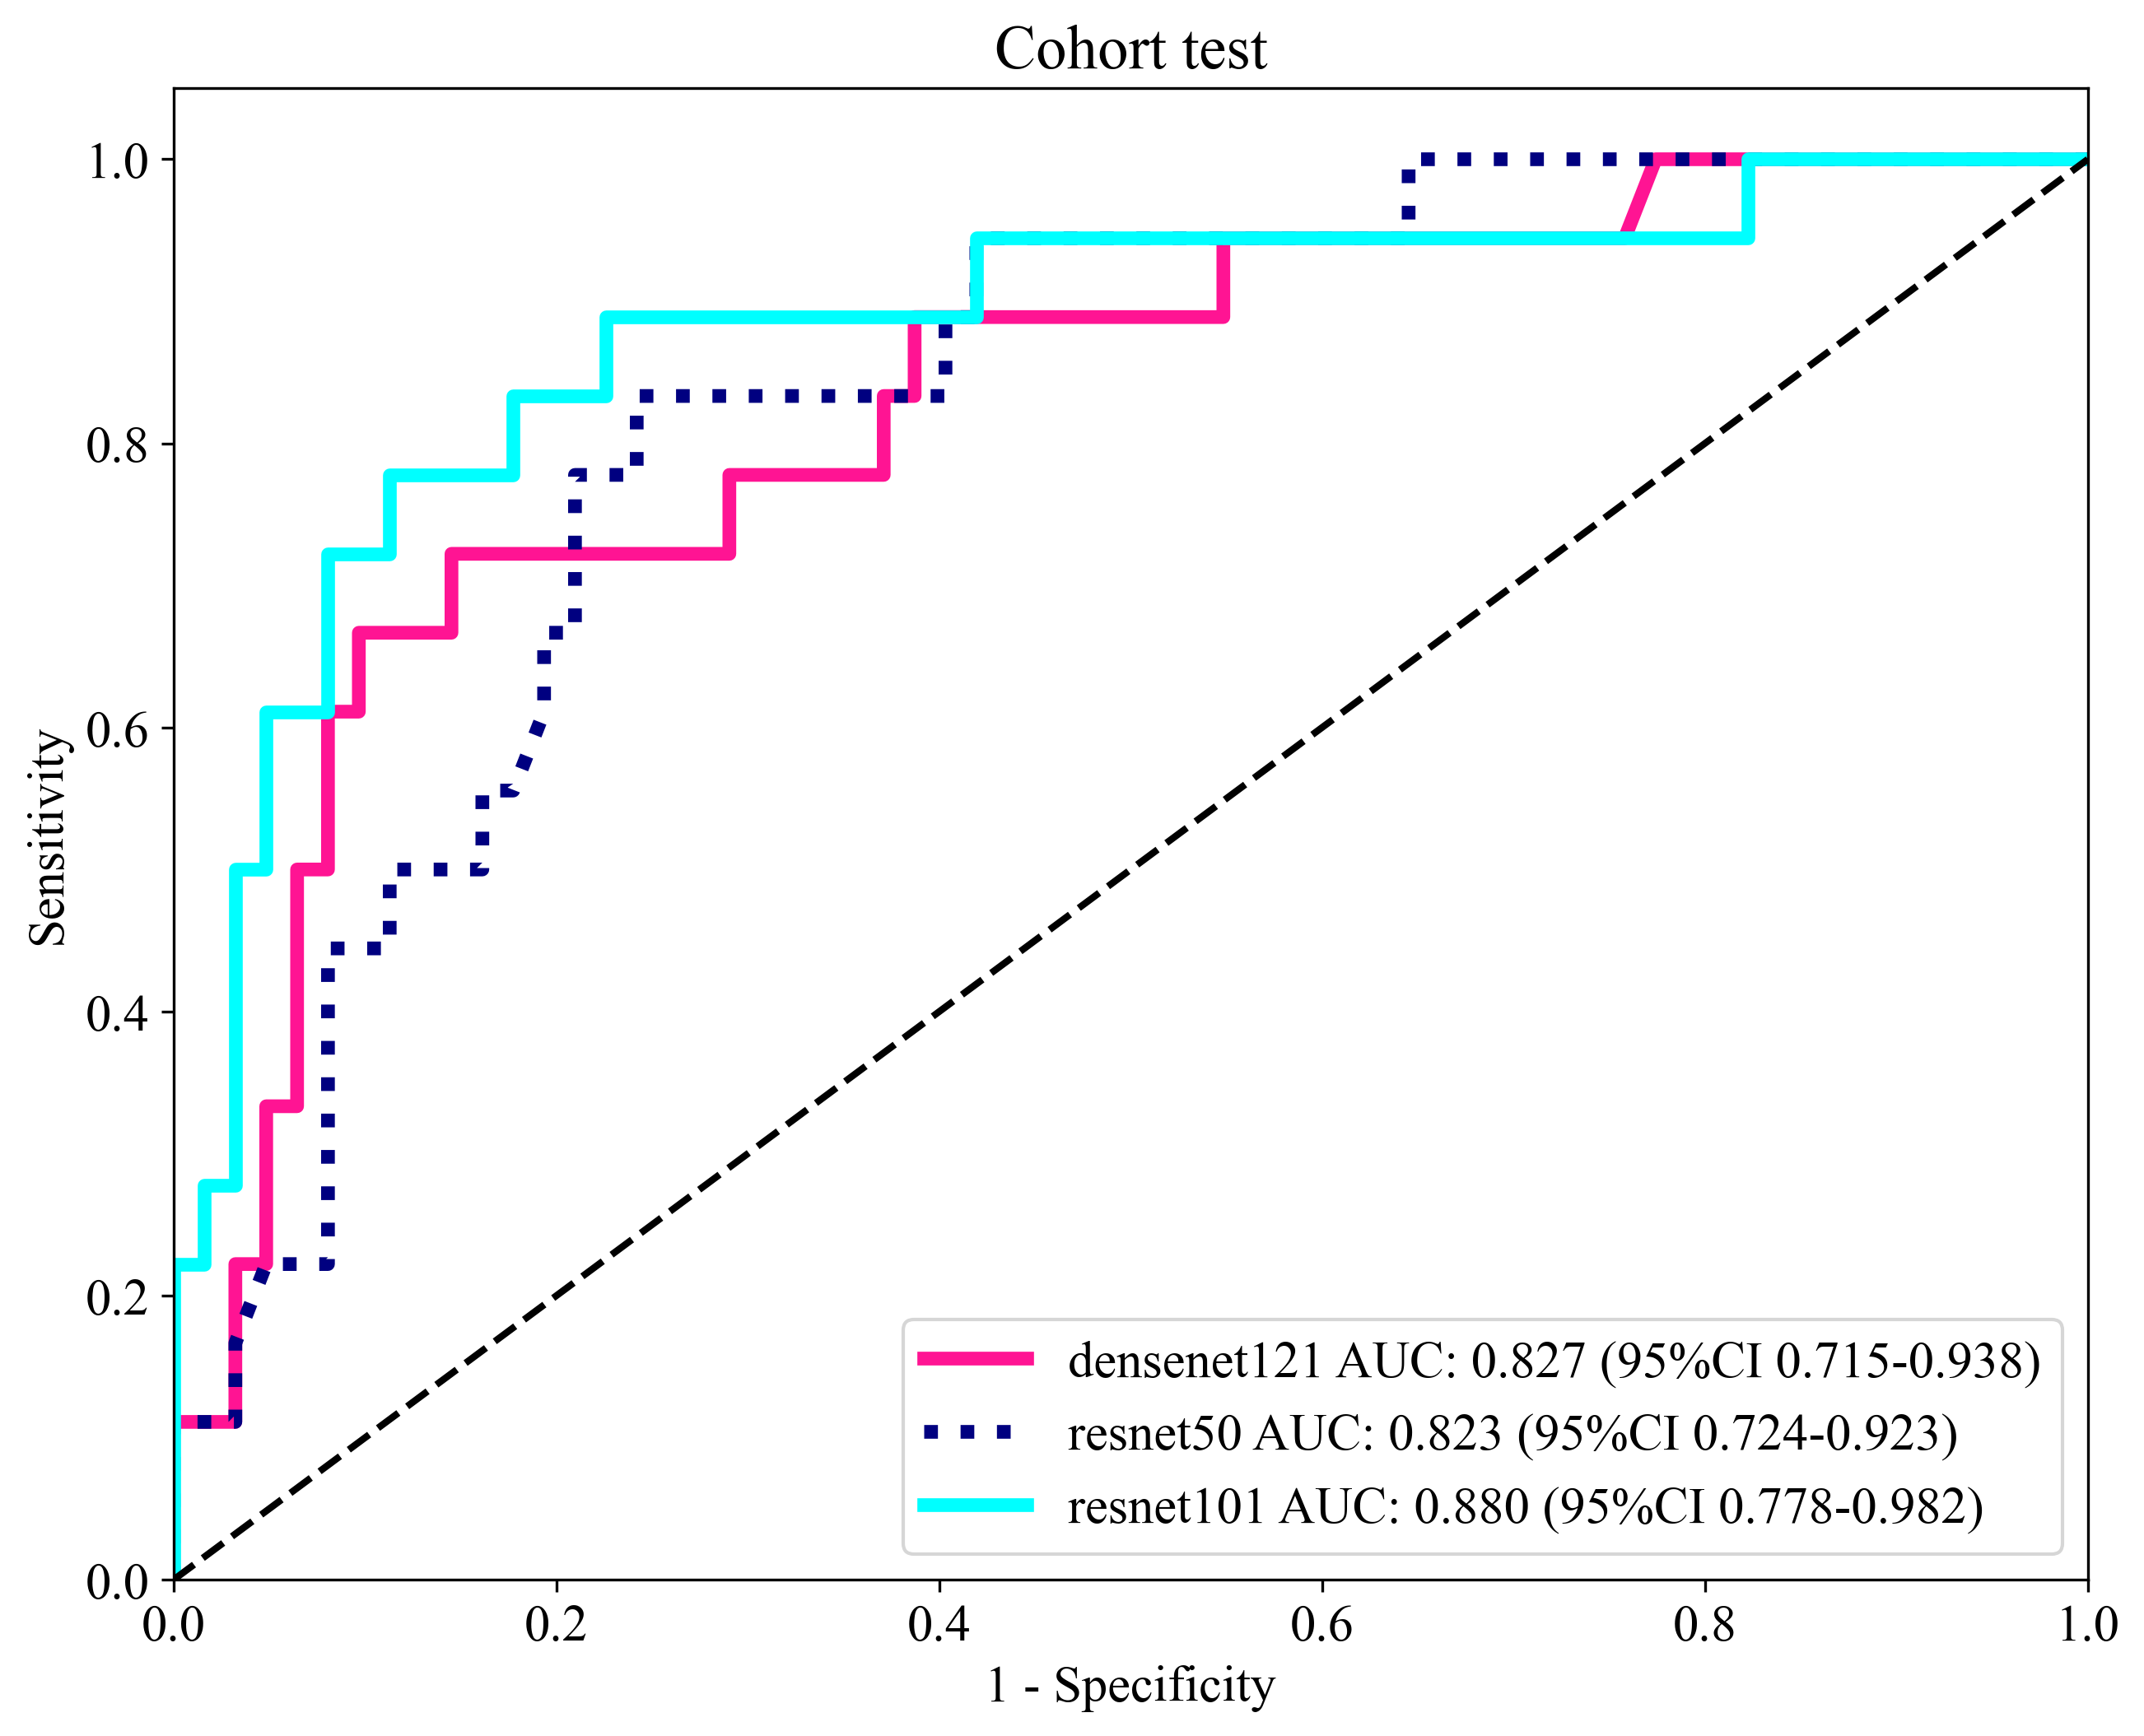

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.808,0.888,0.8217-0.9534,0.857,0.797,0.500,0.959,0.174,CT,train
1,densenet121,0.794,0.843,0.7344-0.9523,0.765,0.804,0.591,0.902,0.261,CT,val
2,densenet121,0.812,0.827,0.7149-0.9383,0.667,0.855,0.571,0.898,0.323,CT,test
3,resnet50,0.863,0.936,0.8912-0.9805,0.821,0.873,0.605,0.954,0.272,CT,train
4,resnet50,0.762,0.832,0.7269-0.9380,0.706,0.783,0.545,0.878,0.301,CT,val
5,resnet50,0.762,0.823,0.7241-0.9228,0.778,0.758,0.483,0.922,0.354,CT,test
6,resnet101,0.815,0.899,0.8378-0.9594,0.786,0.822,0.512,0.942,0.207,CT,train
7,resnet101,0.825,0.880,0.7802-0.9794,0.824,0.826,0.636,0.927,0.236,CT,val
8,resnet101,0.850,0.880,0.7780-0.9818,0.722,0.887,0.650,0.917,0.417,CT,test


,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.808,0.888,0.8217-0.9534,0.857,0.797,0.500,0.959,0.174,CT,train
1,densenet121,0.794,0.843,0.7344-0.9523,0.765,0.804,0.591,0.902,0.261,CT,val
2,densenet121,0.812,0.827,0.7149-0.9383,0.667,0.855,0.571,0.898,0.323,CT,test
3,resnet50,0.863,0.936,0.8912-0.9805,0.821,0.873,0.605,0.954,0.272,CT,train
4,resnet50,0.762,0.832,0.7269-0.9380,0.706,0.783,0.545,0.878,0.301,CT,val
5,resnet50,0.762,0.823,0.7241-0.9228,0.778,0.758,0.483,0.922,0.354,CT,test
6,resnet101,0.815,0.899,0.8378-0.9594,0.786,0.822,0.512,0.942,0.207,CT,train
7,resnet101,0.825,0.880,0.7802-0.9794,0.824,0.826,0.636,0.927,0.236,CT,val
8,resnet101,0.850,0.880,0.7780-0.9818,0.722,0.887,0.650,0.917,0.417,CT,test


In [15]:
import pandas as pd
import numpy  as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
from onekey_algo.custom.components.ugly import drop_error
from matplotlib import pyplot as plt

def get_group(x):
    x = os.path.basename(x)
    if x.startswith('train'):
        return 'train'
    elif x.startswith('val'):
        return 'val'
    else:
        return '_'.join(x.split('_')[:2])

def get_log(log_path, map2gz:bool = True):
    log_ = pd.read_csv(log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
    if map2gz:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x).replace('.png', '.gz'))
    else:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x))
    return log_

def map_mn(x):
    return x.replace('densen', 'DenseN').replace('resnet', 'ResNet').replace('vgg', 'VGG').replace('inception_v3', 'InceptionV3')

all_log = []
metrics_dfs = []
epoch_mapping = {'resnet50': {'CT': 25, 'P': 19, 'V': 18, 'dwi': 15, 't1': 19, 't2': 17, },
                 'resnet101': {'CT': 22, 'P': 19, 'V': 18, 'dwi': 15, 't1': 19, 't2': 17, },
                 'vgg19': {'CT': 22, 'P': 15, 'V': 12, 'dwi': 17, 't1': 19, 't2': 18, },
                 'densenet121': {'CT': 20, 'P': 12, 'V': 19, 'dwi': 18, 't1': 18, 't2': 15, }}
dsamples = {'val': set(), 'test': set()}
for modal in get_param_in_cwd('modals', ['CT']):
    for epoch_ in range(29, 30):
        for cv in range(8, 9):
            model_root = os.path.join(get_param_in_cwd('radio_dir'), 'vnet_models_full')
            metric_results = []
            all_preds = []
            all_gts = []
            all_model_names = []
            for model in ['densenet121', 'resnet50', 'resnet101']:
                if model != 'resnet101' and False:
                    continue
                all_pred = []
                all_gt = []
                all_groups = []
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"viz/BST_TRAIN_RESULTS.txt")),
#                                     get_log(os.path.join(model_root, model, f"viz/BST_VAL_RESULTS.txt"))], axis=0)
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_}.txt")),
#                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_}.txt"))], axis=0)
                val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_mapping[model][modal]}.txt")),
                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_mapping[model][modal]}.txt"))], axis=0)
                val_log = pd.merge(val_log, group_info, on='ID', how='inner')
                val_log['model'] = f"{model}_{modal}"
                # display(val_log)
                ug_groups = np.unique(val_log['group'])
                ug_groups = ['train', 'val', 'test']
                ul_labels = np.unique(val_log['pred_label'])
                for g in ug_groups:
                    sub_group = val_log[val_log['group'] == g]
                    if g in ['val'] and False:
                        if modal in ['CT']:
                            if len(dsamples[g]) < (1 if g == 'val' else 8):
                                sel_idx, = drop_error([sub_group['pred_label']], [sub_group['gt']], [sub_group['pred_score']], 
                                                      ratio=1 if g == 'val' else 4, verbose=True)
                                print(g, sub_group.shape, sub_group[sel_idx].shape, 
                                      set(sub_group['fname'])-set(sub_group[sel_idx]['fname']))
                                drop_s = set(sub_group['fname'])-set(sub_group[sel_idx]['fname'])
                                dsamples[g] |= set([os.path.basename(s).replace('.png', '.gz') for s in drop_s])
                        sub_group = sub_group[~sub_group['ID'].isin(dsamples[g])]
                    print(modal, epoch_, cv, g, sub_group.shape)
                    all_log.append(sub_group)
                    sub_group['label-1'] = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], 
                                                    np.array(sub_group[['pred_score', 'pred_label']])))
                    sub_group['label-0'] = 1 - sub_group['label-1']
                    sub_group[['ID', 'label-0', 'label-1']].to_csv(os.path.join('results', f'DL_{model}_{g}.csv'), index=False)
                    all_groups.append(g)
                    for ul in [1]:
                        pred_score = np.array(sub_group['label-1'])
                        gt = [1 if gt_ == ul else 0 for gt_ in np.array(sub_group['gt'])]
                        acc, auc, ci, tpr, tnr, ppv, npv, _, _, _, thres = metrics.analysis_pred_binary(gt, pred_score, use_youden=True)
                        ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
                        metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, thres, modal, g])
                        all_pred.append(pred_score)
                        all_gt.append(gt)
                # 绘制每个模型的ROC
                draw_roc(all_gt, all_pred, labels=all_groups, title=f"Modal: {modal}, Model: {map_mn(model)}")
                plt.savefig(f'img/DL_{model}_roc.svg', bbox_inches='tight')
                plt.show()
                # 整合到所有模型汇总。
                all_preds.extend(all_pred)
                all_gts.extend(all_gt)
                all_model_names.append(model)
            for gi, g in enumerate(all_groups):
                draw_roc(all_gts[gi::len(all_groups)], all_preds[gi::len(all_groups)], labels=all_model_names, 
                         title=f"Cohort {g}")
                plt.savefig(f'img/DL_{g}_roc.svg', bbox_inches='tight')
                plt.show()
            metrics_df = pd.DataFrame(metric_results, 
                         columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                                  'Youden', 'Modal', 'Cohort'])
            display(metrics_df)
            metrics_dfs.append(metrics_df)
            
all_log = pd.concat(all_log, axis=0)
all_log['ID'] = all_log['fname'].map(lambda x: os.path.basename(x))
pd.concat(metrics_dfs, axis=0)

In [4]:
all_log

,fname,pred_score,pred_label,gt,ID,group,model,label-1,label-0
0,D:\20240420-LiXiaoFeng\vnet_crop_full\LIU FU C...,0.950,0,0,LIU FU CAI_P00084450.nii.png,train,densenet121_CT,0.050,0.950
1,D:\20240420-LiXiaoFeng\vnet_crop_full\LIU_XIU_...,0.577,0,0,LIU_XIU_YUN_P00194230.nii.png,train,densenet121_CT,0.423,0.577
2,D:\20240420-LiXiaoFeng\vnet_crop_full\GENG MEI...,0.642,0,0,GENG MEI YUN_P00139703.nii.png,train,densenet121_CT,0.358,0.642
3,D:\20240420-LiXiaoFeng\vnet_crop_full\MA XIANG...,0.719,0,0,MA XIANG YINP00352062.nii.png,train,densenet121_CT,0.281,0.719
4,D:\20240420-LiXiaoFeng\vnet_crop_full\LIU JING...,0.933,0,0,LIU JINGP00360405.nii.png,train,densenet121_CT,0.067,0.933
...,...,...,...,...,...,...,...,...,...
278,D:\20240420-LiXiaoFeng\vnet_crop_full\Liu-Qinh...,0.781,0,0,Liu-Qinhua-P00353679.nii.png,test,resnet101_CT,0.219,0.781
281,D:\20240420-LiXiaoFeng\vnet_crop_full\Lei-Zuol...,0.505,1,0,Lei-Zuoliang-P00334848.nii.png,test,resnet101_CT,0.505,0.495
284,D:\20240420-LiXiaoFeng\vnet_crop_full\ZHANG_FE...,0.805,1,1,ZHANG_FEN_YUN_P00410862.nii.png,test,resnet101_CT,0.805,0.195
287,D:\20240420-LiXiaoFeng\vnet_crop_full\Chen-Shu...,0.999,0,0,Chen-Shuxiang-P00364924.nii.png,test,resnet101_CT,0.001,0.999


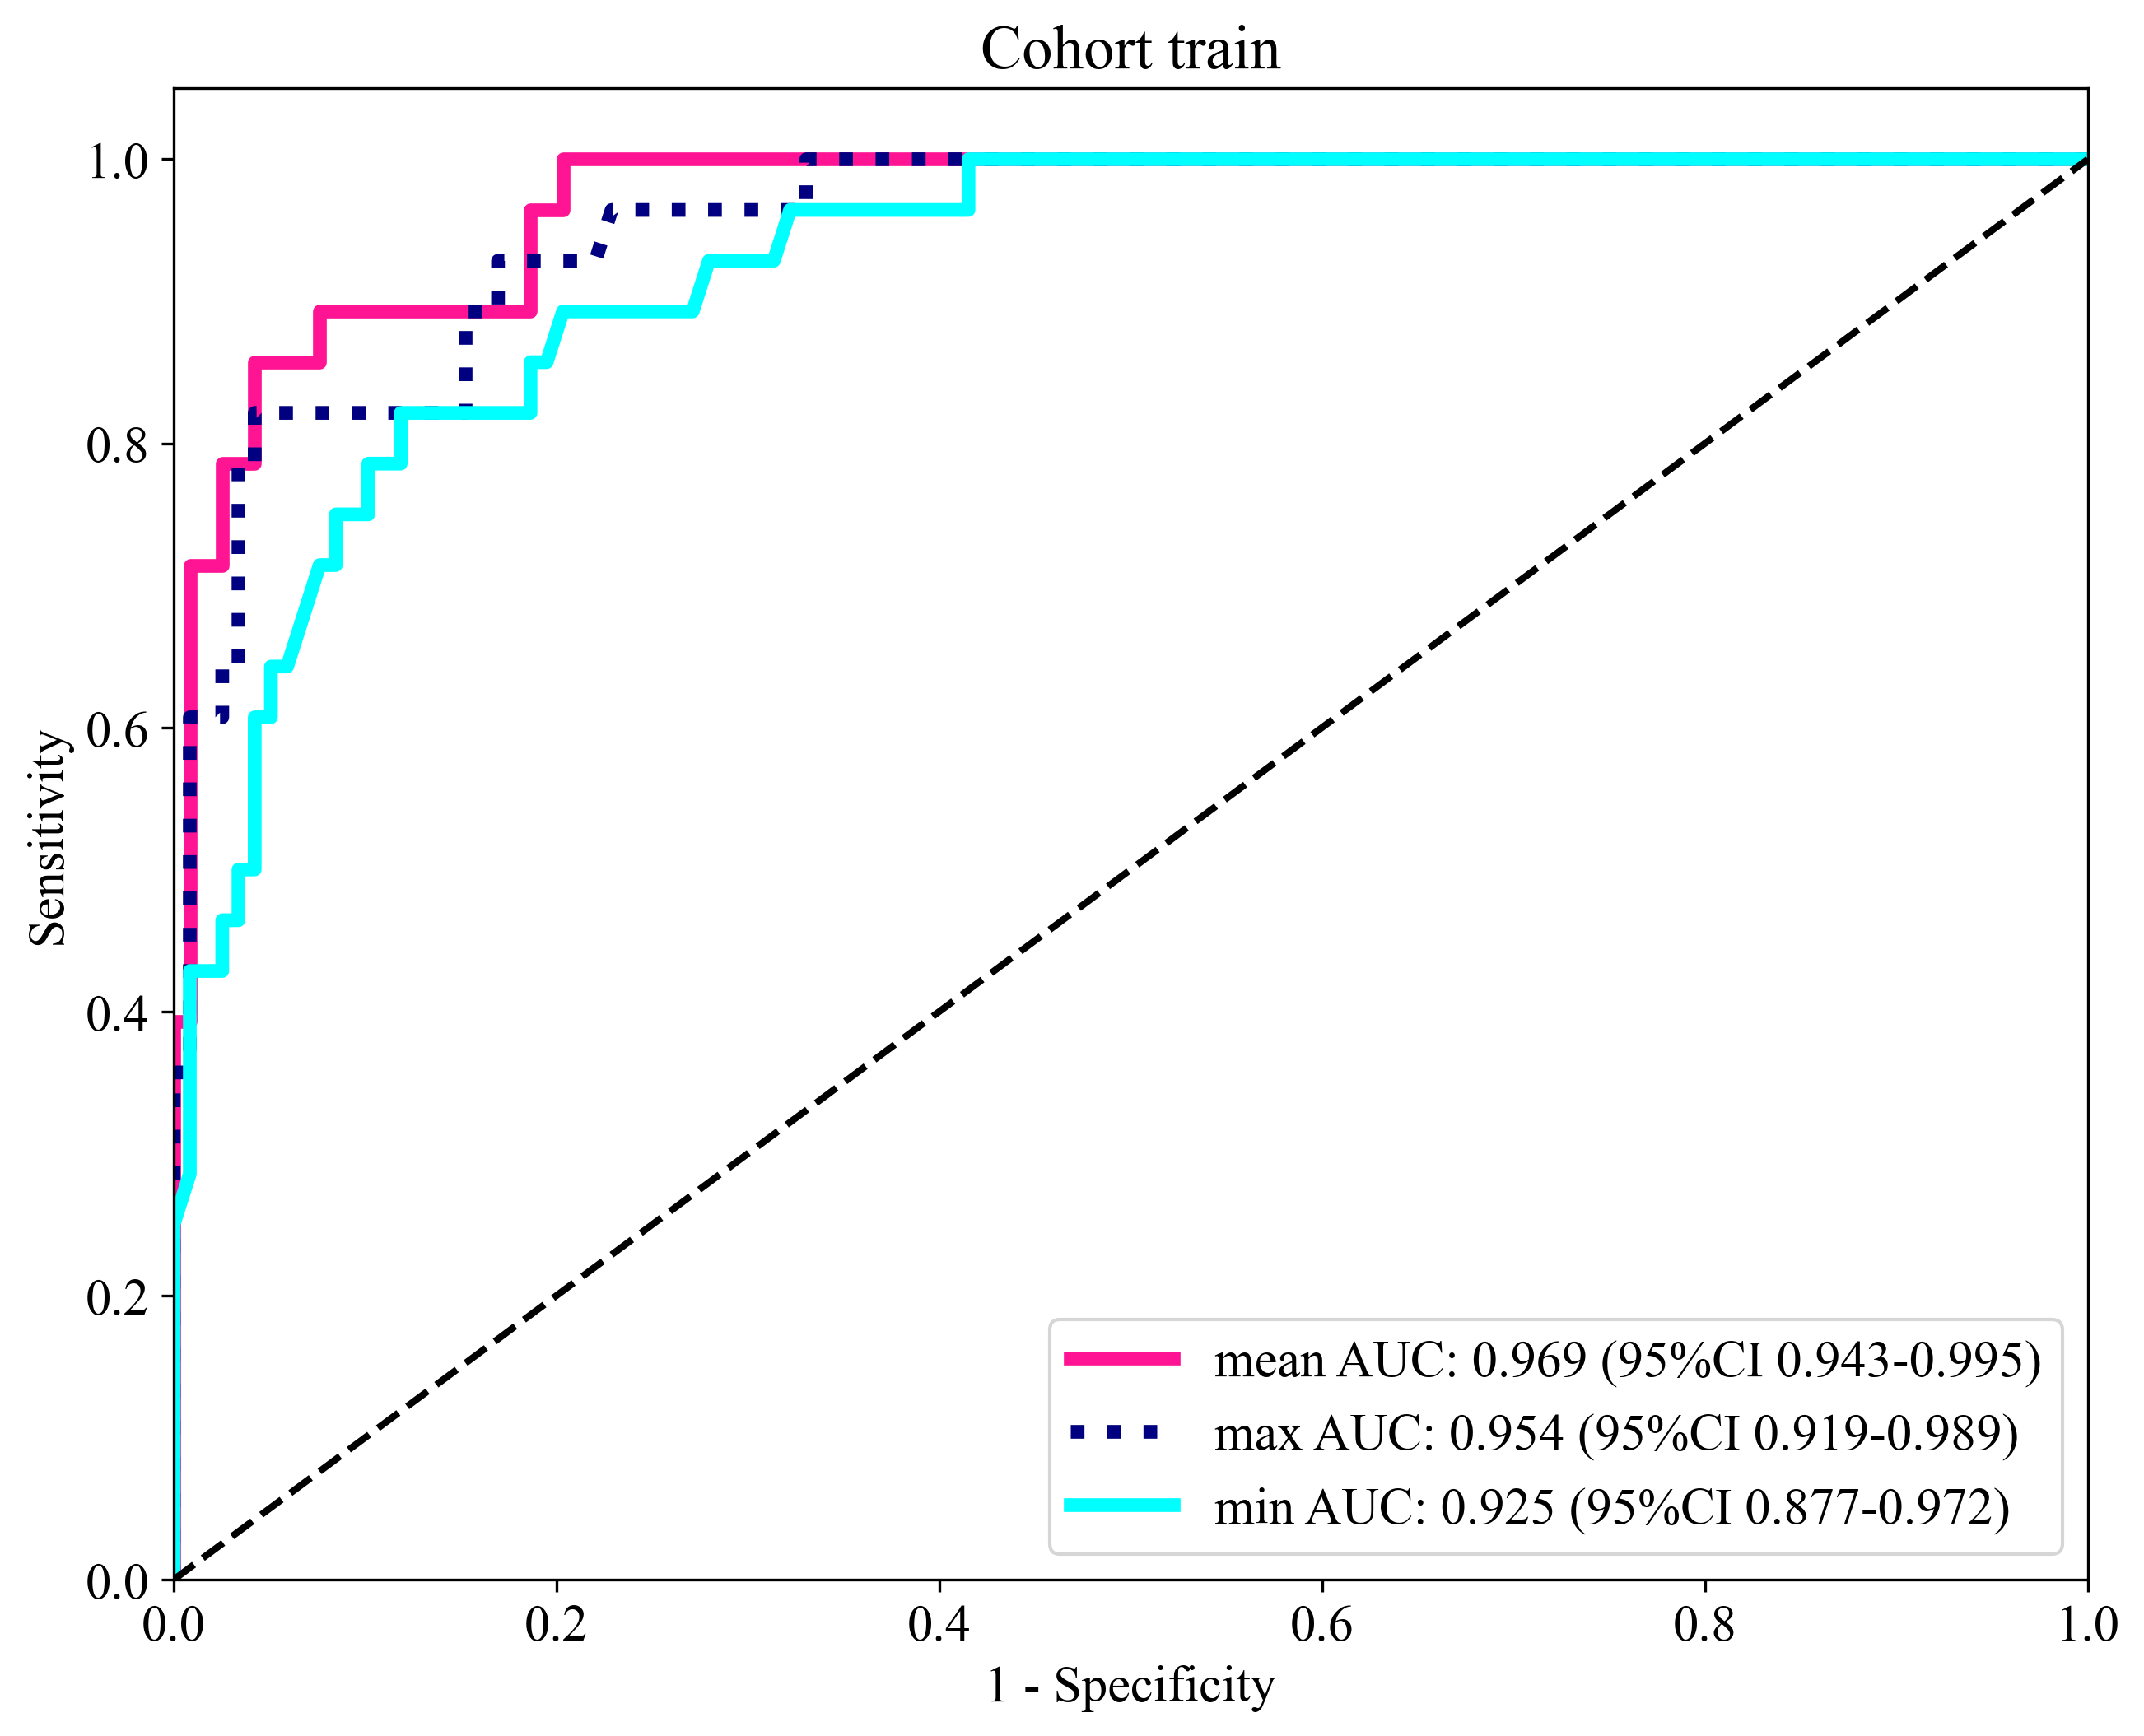

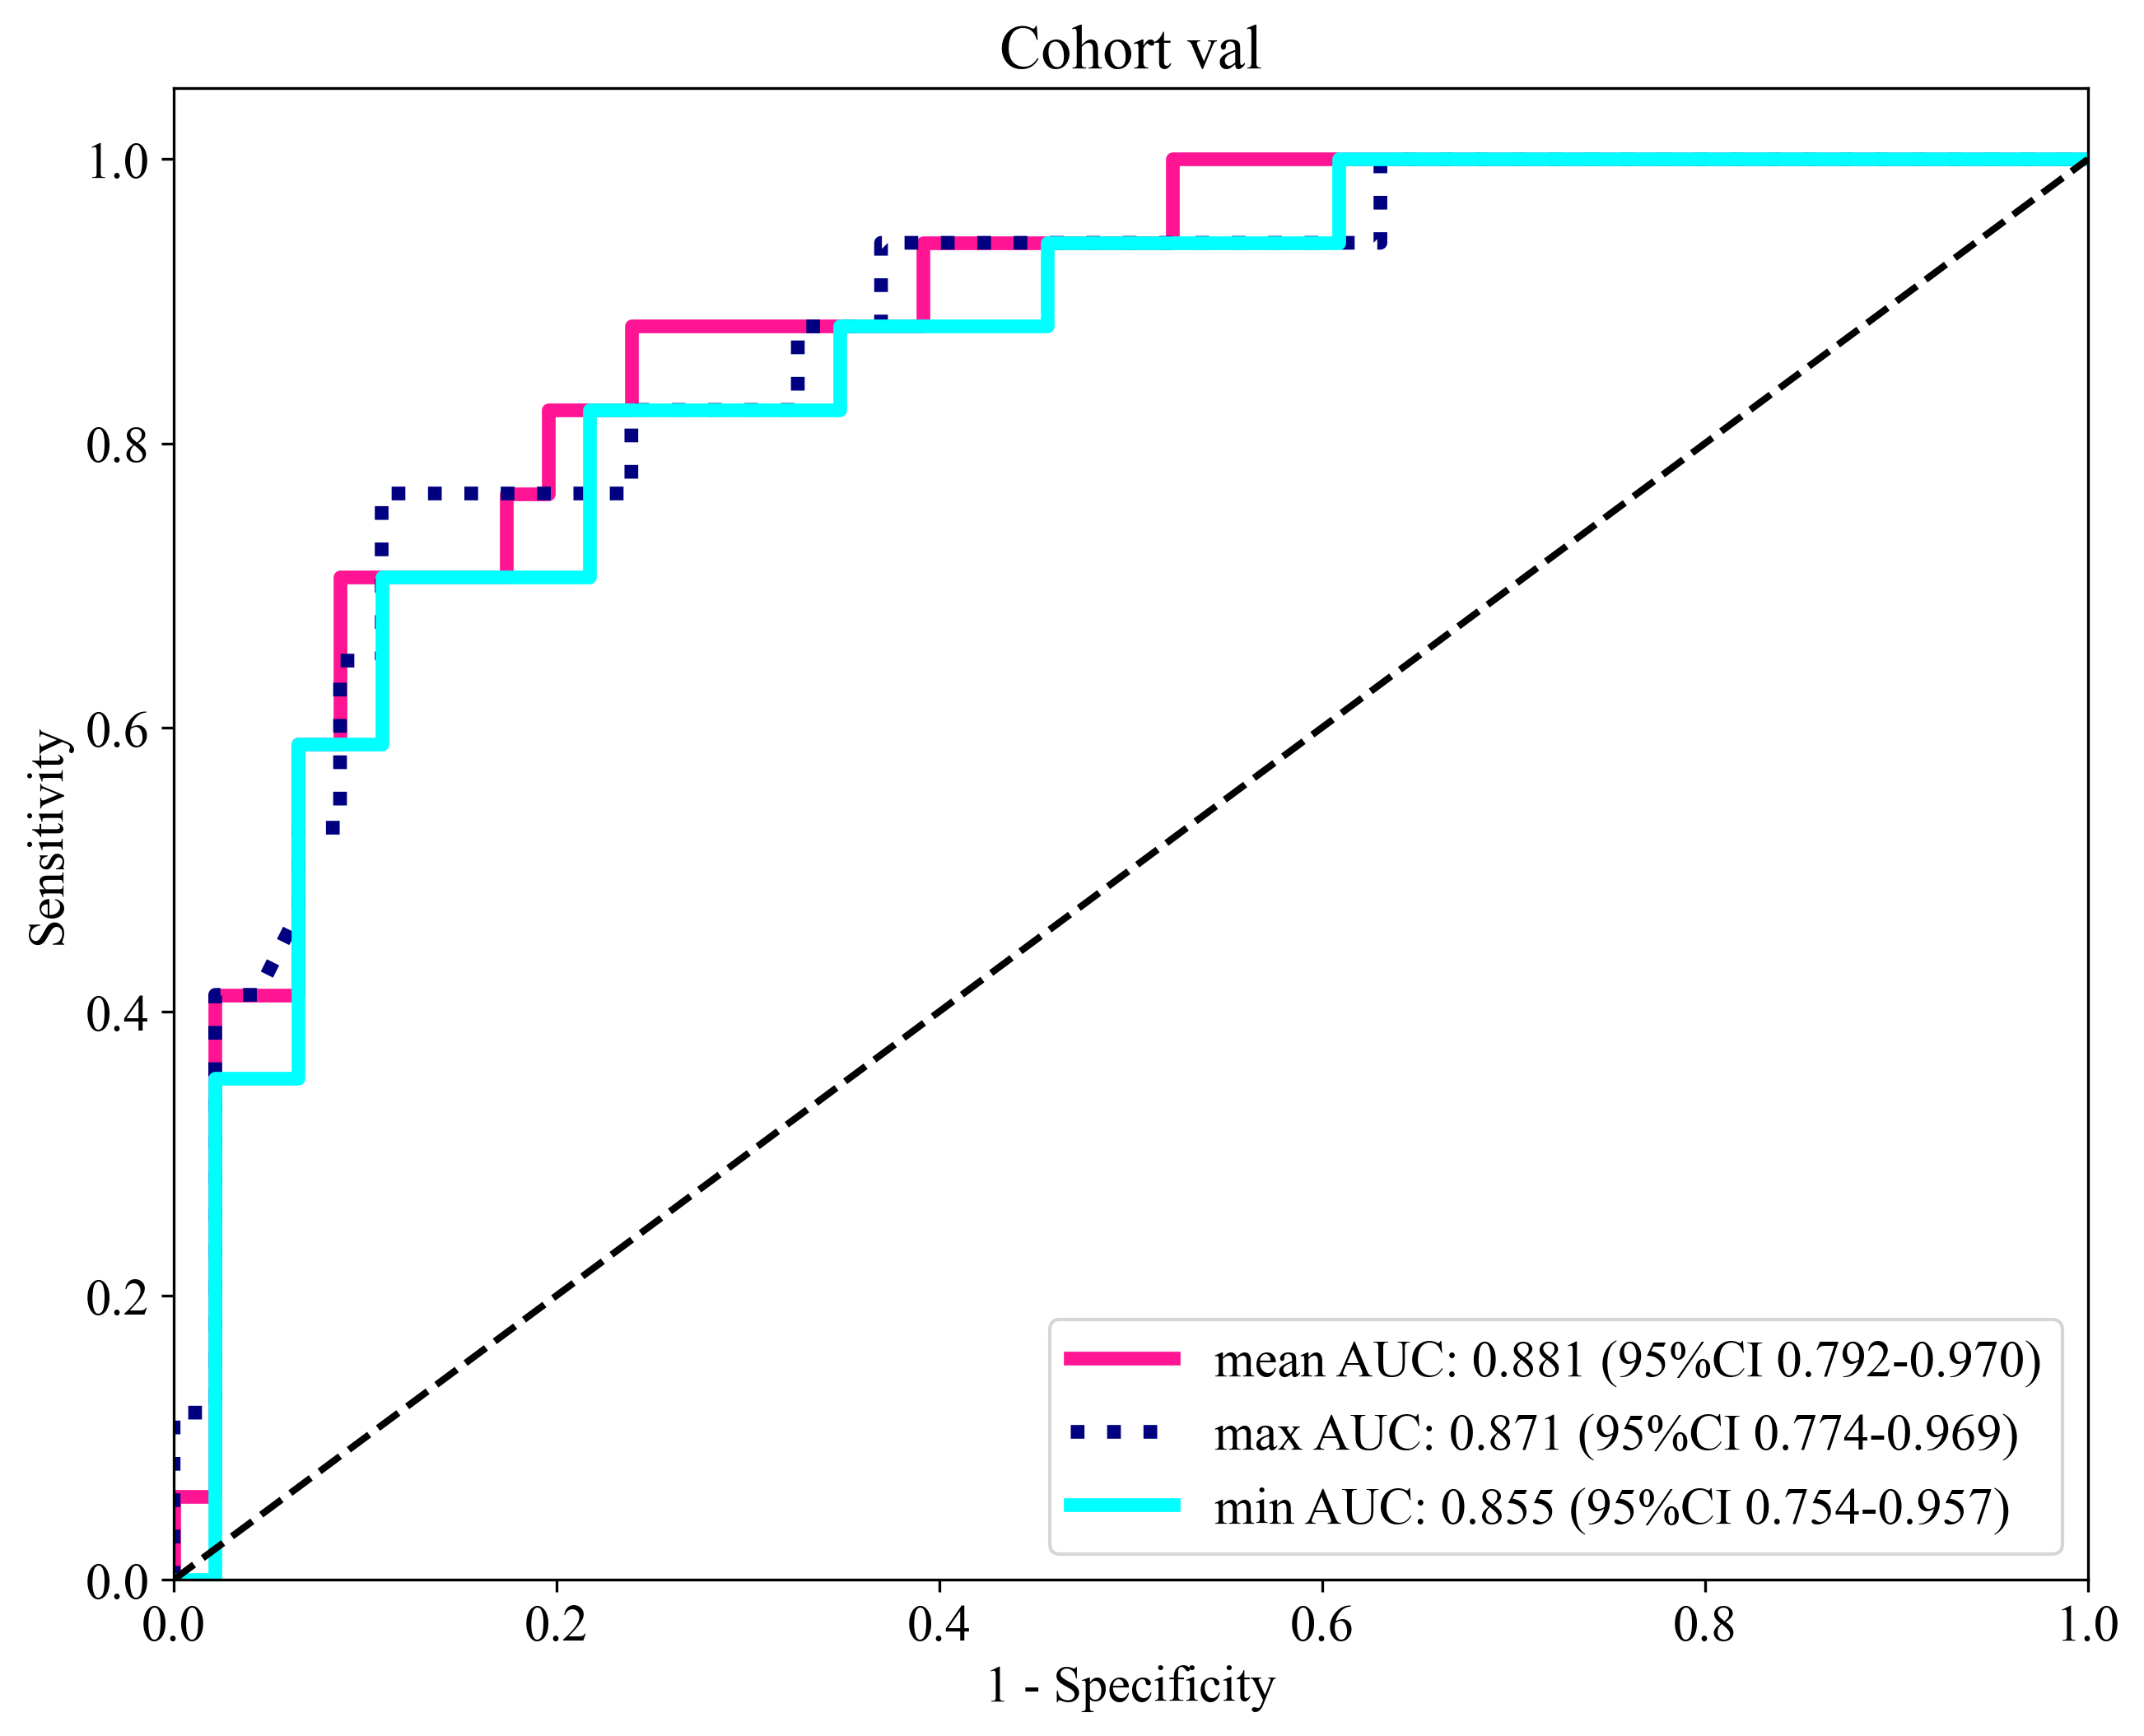

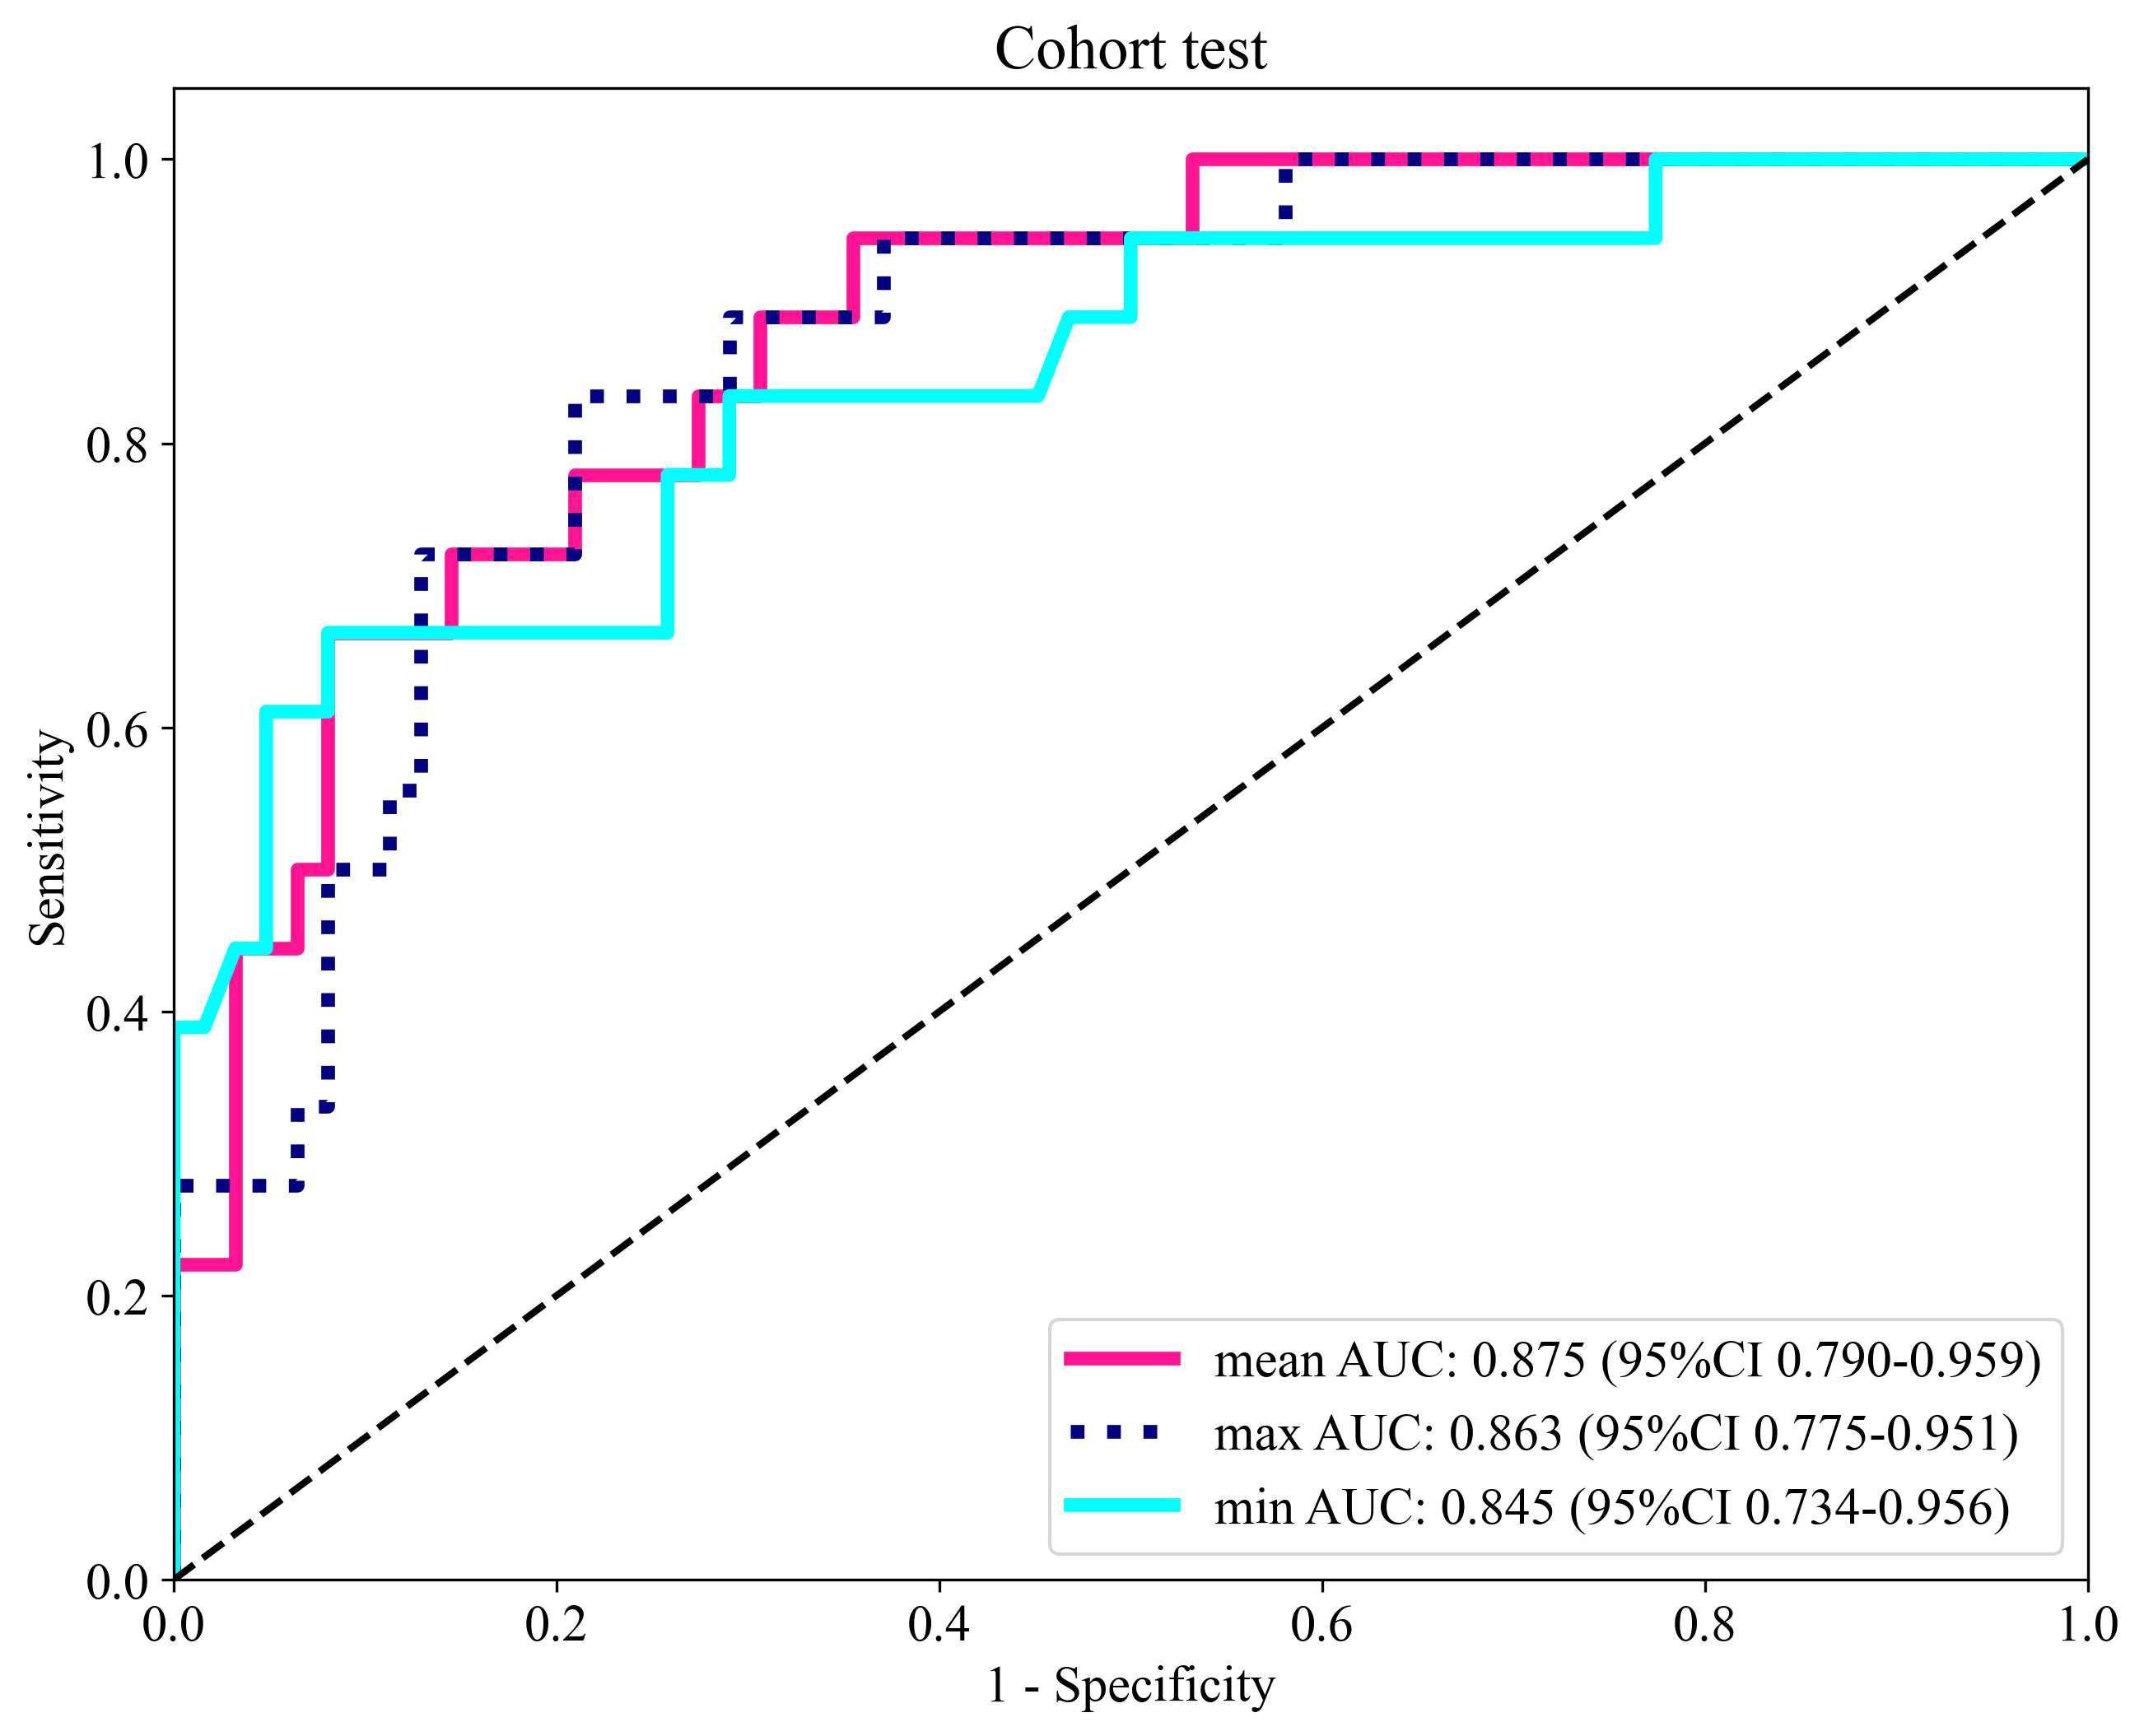

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,resnet101,0.911,0.969,0.9428-0.9954,0.857,0.924,0.727,0.965,0.290,mean,train
1,resnet101,0.925,0.954,0.9186-0.9891,0.786,0.958,0.815,0.950,0.486,max,train
2,resnet101,0.863,0.925,0.8774-0.9719,0.786,0.881,0.611,0.945,0.134,min,train
3,resnet101,0.778,0.881,0.7920-0.9702,0.824,0.761,0.560,0.921,0.221,mean,val
4,resnet101,0.841,0.871,0.7743-0.9687,0.706,0.891,0.706,0.891,0.423,max,val
5,resnet101,0.778,0.855,0.7535-0.9575,0.765,0.783,0.565,0.900,0.163,min,val
6,resnet101,0.700,0.875,0.7904-0.9587,0.889,0.645,0.421,0.952,0.193,mean,test
7,resnet101,0.787,0.863,0.7752-0.9506,0.778,0.790,0.519,0.925,0.417,max,test
8,resnet101,0.850,0.845,0.7339-0.9561,0.611,0.919,0.687,0.891,0.323,min,test


In [14]:
from onekey_algo.custom.components.ugly import drop_error

metric_results = []
sel_data = []
for g in all_groups:
    gts = []
    preds = []
    methods = ['mean', 'max', 'min']
    for method in methods:
        sub_group = all_log[(all_log['group'] == g)]
        sub_group = sub_group.groupby('ID').agg(method).reset_index()
        sub_group['group'] = g
        sub_group['pred_label'] = sub_group['label-1'].map(lambda x: 1 if x > 0.5 else 0)
        sub_group['pred_score'] = sub_group['label-1'].map(lambda x: x if x > 0.5 else 1-x)
        if g in ['Test'] and False:
            if method == 'mean':
                sel_idx, = drop_error([sub_group['pred_label']], [sub_group['gt']], [sub_group['pred_score']], ratio=3, 
                                      verbose=True)
                print(method, g, sub_group.shape, sub_group[sel_idx].shape, set(sub_group['ID'])-set(sub_group[sel_idx]['ID']))
            sub_group = sub_group[sel_idx]
        sub_group[['ID', 'label-0', 'label-1']].to_csv(os.path.join('results', f'DL_{method}_{g}.csv'), index=False)
#         display(sub_group)
        sel_data.append(sub_group[['ID', 'gt', 'label-1', 'group']])
        gt = np.array(sub_group['gt'])
        pred_score = np.array(sub_group['label-1'])
        gts.append(gt)
        preds.append(pred_score)
        acc, auc, ci, tpr, tnr, ppv, npv, _, _, _, thres = metrics.analysis_pred_binary(gt, pred_score, use_youden=True)
        ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
        metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, 
                               thres, method, g])
    draw_roc(gts, preds, labels=methods,  title=f"Cohort {g}")
    plt.savefig(f'img/DTL_Fusion_{g}_roc.svg', bbox_inches='tight')
    plt.show()
metrics_df = pd.DataFrame(metric_results, 
                     columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
#                               'Precision', 'Recall', 'F1', 'Threshold', 
                              'Youden', 'Modal', 'Cohort'])
display(metrics_df)